___Aim:___


  - Upon receiving a loan application, the business must decide whether to approve the loan based on the applicant's profile.

  - Granting the loan could result in a loss of money for the company if the borrower is not likely to repay the debt, or if default is probable.

  - The purpose of the analysis is to identify the crucial variables that are <span style='color:green'>solid indicators</span> of loan <span style='color:green'>defaults</span> so that those making decisions can minimize the likelihood of default risk by utilizing them to accept or reject loan applications.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
import seaborn as sns
import re
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

In [2]:
loans_data = pd.read_csv('loan.csv', header=0, sep=',')

In [3]:
loans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [4]:
loans_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.000,36 months,10.65%,162.870,B,B2,...,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.000,60 months,15.27%,59.830,C,C4,...,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.000,36 months,15.96%,84.330,C,C5,...,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.000,36 months,13.49%,339.310,C,C1,...,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.000,60 months,12.69%,67.790,B,B5,...,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN


In [5]:
loans_data['loan_status'].value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64

#### Selecting the borrowers whose loans were either `Charged off` or `Fully Paid`. 
- The **current** borrowers are those who are still in the process of repaying their loans. Over time, their repayment patterns will evolve. <br>Therefore, comparing their current performance to that of debtors who have already defaulted will not be helpful. However, we should examine how the borrowers who have fallen behind on their payments stand up against those who have paid off their debt entirely, in order to understand why borrowers tend to default.

In [6]:
loans_defaults_or_paid = loans_data[loans_data.loan_status.isin(['Charged Off', 'Fully Paid'])].reset_index(drop=True)

In [7]:
loans_defaults_or_paid['loan_status'].value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Name: count, dtype: int64

#### Checking the number of filtered rows

In [8]:
loans_defaults_or_paid.shape

(38577, 111)

#### Fixing Columns
- Drop the columns having only `one unique non-null` value

In [9]:
single_valued_col = loans_defaults_or_paid.apply(lambda x:x.dropna().nunique(), axis=0)==1
loans_defaults_or_paid.drop(single_valued_col[single_valued_col].index, axis=1, inplace=True)

- Drop irrelevant columns


  - The following variables will explain the borrower's conduct over the course of the loan after the loan application is approved and the borrower receives the funds. These variables can be eliminated as the lender will not have them while deciding whether to approve or deny the loan application.
    - revol_bal, revol_util, recoveries, collection_recovery_fee, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d
  - **zip_code** is not fully available since it contains sensitive information, so we can drop it.
  - **member_id** is an identifier; it is not analytically useful factual data. It is therefore droppable. Instead, in the event of a merging operation, will utilize `id` column
  - A few more variables which are stated below, can be removed because the information they contain is not crucial enough to determine if the applicant would default.
    - url, title, desc, emp_title
  

In [10]:
loans_defaults_or_paid.drop(['url', 'member_id', 'title', 'desc', 'emp_title', 
                             'funded_amnt', 'last_credit_pull_d',
                             'mths_since_last_record', 'total_pymnt',
                             'total_pymnt_inv', 'total_rec_prncp',
                             'total_rec_int', 'total_rec_late_fee', 
                             'revol_bal', 'revol_util',
                             'recoveries', 'collection_recovery_fee', 'zip_code',
                             'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d'],
                             inplace=True, axis=1)

#### Missing Values

- Find columns with missing values. Determine percentage of missing values in each column

In [11]:
nan_cols = loans_defaults_or_paid.isna().sum()[loans_defaults_or_paid.isna().sum()>0]
percentage_nan_cols = (round(nan_cols/len(loans_defaults_or_paid) * 100, 2)).sort_values(ascending=False)
percentage_nan_cols

mo_sin_old_rev_tl_op             100.000
num_op_rev_tl                    100.000
mort_acc                         100.000
mths_since_recent_bc             100.000
mths_since_recent_bc_dlq         100.000
mths_since_recent_inq            100.000
mths_since_recent_revol_delinq   100.000
num_accts_ever_120_pd            100.000
num_actv_bc_tl                   100.000
num_actv_rev_tl                  100.000
num_bc_sats                      100.000
num_bc_tl                        100.000
num_il_tl                        100.000
num_rev_accts                    100.000
mo_sin_rcnt_rev_tl_op            100.000
num_rev_tl_bal_gt_0              100.000
num_sats                         100.000
num_tl_120dpd_2m                 100.000
num_tl_30dpd                     100.000
num_tl_90g_dpd_24m               100.000
num_tl_op_past_12m               100.000
pct_tl_nvr_dlq                   100.000
percent_bc_gt_75                 100.000
tot_hi_cred_lim                  100.000
total_bal_ex_mor

- Drop columns with 100% missing values

In [12]:
columns_to_drop = [k for k, v in percentage_nan_cols.items() if v==100]
loans_defaults_or_paid.drop(columns_to_drop, axis=1, inplace=True)

In [13]:
loans_defaults_or_paid.columns.size

25

- Find rows that only have missing values

In [14]:
nan_rows = loans_defaults_or_paid.isna().sum(axis=1)[loans_defaults_or_paid.isna().sum(axis=1)>0]
percentage_nan_rows = round(nan_rows/loans_defaults_or_paid.shape[1]*100, 2)
nan_only_rows = (percentage_nan_rows == 100).sum()
nan_only_rows

0

In [15]:
loans_defaults_or_paid.columns

Index(['id', 'loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
       'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'total_acc', 'pub_rec_bankruptcies'],
      dtype='object')

#### Checking for Duplication

1) Determine the number of duplicate rows

In [16]:
loans_defaults_or_paid.duplicated().sum()

0

2_ Determine the number of duplicate indicators `id`

In [17]:
loans_defaults_or_paid.id.duplicated().sum()

0

#### Explore common statistics

In [18]:
print('Total number of Columns:',loans_defaults_or_paid.shape[1])
print('Total number of Rows:',loans_defaults_or_paid.shape[0])
print('Total number of missing values:',loans_defaults_or_paid.isna().sum(axis=0).sum())

Total number of Columns: 25
Total number of Rows: 38577
Total number of missing values: 26635


#### Determine the count of unique values in each column

In [19]:
loans_defaults_or_paid.nunique(axis=0).sort_values(ascending=False).to_frame(name='num_unique_val').merge(
    loans_defaults_or_paid.dtypes.to_frame(name='datatypes'),
    how='inner',
    left_index=True,
    right_index=True
)

,num_unique_val,datatypes
id,38577,int64
installment,15022,float64
funded_amnt_inv,8050,float64
annual_inc,5215,float64
dti,2853,float64
loan_amnt,870,int64
earliest_cr_line,524,object
int_rate,370,object
mths_since_last_delinq,95,float64
total_acc,82,int64


#### Invalid Values

1) Convert the datatypes of the columns

      - <span style='color:blue'>issue_d</span>
        - Dates are available as strings. Parse them into datetime objects
      - <span style='color:blue'>earliest_cr_line</span> 
        -  Since the dates are provided as strings, we must parse them. However, before to parsing, the following must be done:
            
            
            - A <span style='color:brown'>two-digit</span> number representing the year for each date. For the earliest credit line years 1925 to 1968, we have 25 to 68, which Python will interpret incorrectly as 2025 to 2068. 
            
            - Hence, first, reformat the years to have four digits, such as 1948, 1965, etc., and then parse them into datetime objects. 
            
            - Created the function `def reformat_year()` that modifies the earliest_cr_line years.

In [20]:
def reformat_year(dframe, col_name, ):
    try:
        pattern_1925_1999 = '|'.join(np.arange(25, 100).astype(str))
        pattern_2000_2009 = [*map(lambda x:'0'+x, np.arange(0, 10).astype(str).tolist())]
        pattern_2010_2024 = np.arange(10, 25).astype(str)
        pattern_2000_2024 = '|'.join(np.concatenate((pattern_2000_2009, pattern_2010_2024)))
        dframe[col_name] = dframe[col_name].map(lambda x: re.sub(pattern_2000_2024, '20'+x[-2:], x))
        dframe[col_name] = dframe[col_name].map(lambda x: re.sub(pattern_1925_1999, '19'+x[-2:], x))
    except Exception as e:
        raise e

In [21]:
# reformat and parse >>> earliest_cr_line
reformat_year(loans_defaults_or_paid, 'earliest_cr_line')
loans_defaults_or_paid.earliest_cr_line = pd.to_datetime(loans_defaults_or_paid.earliest_cr_line, format='%b-%Y')

# parse into datetime >>> issue_d
loans_defaults_or_paid.issue_d = pd.to_datetime(loans_defaults_or_paid.issue_d, format='%b-%y')

2) Determine if the number open credit lines (<span style='color:blue'>open_acc</span>) is greater than the total credit lines (<span style='color:blue'>total_acc</span>) for any borrower in the dataset, which would be invalid. If found, replace them with missing values

In [22]:
print(f'The number of invalids where "open_acc" is greater than "total_acc": '
      f'{(loans_defaults_or_paid.open_acc > loans_defaults_or_paid.total_acc).sum()}')

The number of invalids where "open_acc" is greater than "total_acc": 1


In [23]:
# replace the invalid entries in open_acc/total_acc as missing values
loans_defaults_or_paid.loc[loans_defaults_or_paid.open_acc > loans_defaults_or_paid.total_acc, ['open_acc', 'total_acc']] = np.nan

3) Determine if any loan <span style='color:blue'>installment</span> is greater than the funded amount from investor (<span style='color:blue'>funded_amnt_inv</span>), then it will considered invalid. If found, replace them with missing values

In [24]:
print(f'The number of invalids where "installment" is greater than "funded_amnt_inv": '
      f'{(loans_defaults_or_paid.installment > loans_defaults_or_paid.funded_amnt_inv).sum()}')

The number of invalids where "installment" is greater than "funded_amnt_inv": 215


4) Determine Invalid values in dates
   - <u>Note</u>: As date is measured on an interval scale, we can determine the difference between them

   
     - Identify the invalids where the <span style='color:blue'>issue_d</span> may be discovered earlier than the <span style='color:blue'>earliest_cr_line</span>. If found, replace them with missing values

In [25]:
print(f'The number of invalids where "issue_d" is earlier than "earliest_cr_line": '
      f'{(loans_defaults_or_paid[["issue_d", "earliest_cr_line"]].apply(lambda x:x[0]-x[1], axis=1)<datetime.timedelta(days=0)).sum()}')

The number of invalids where "issue_d" is earlier than "earliest_cr_line": 0


#### Standardization and Datatype Conversion
- int_rate - Remove suffix `%` and convert into `float` type
- term - Remove leading and trailing spaces

In [26]:
loans_defaults_or_paid['int_rate'] = loans_defaults_or_paid.int_rate.str.replace('%', '').apply(np.float32)
loans_defaults_or_paid.term = loans_defaults_or_paid.term.str.strip()

#### Derive Metrics from Dates

1) Create a function that extracts the <span style="color:green">month</span> and <span style="color:green">year</span> as ***Type Driven Metrics*** from the date columns

In [27]:
def get_metrics_from_date(dframe, index_column):
    if not isinstance(index_column, str):
        raise TypeError(f'{index_column} must be a str.')        
    if isinstance(dframe, pd.DataFrame):
        try:
            dframe1 = dframe.set_index(index_column).select_dtypes('datetime')
            date_col_names = dframe1.keys()
            new_col_names = date_col_names.str.replace('_d', '')
            for i, j in zip(date_col_names, new_col_names):
                dframe1[f'{j}_month'] = dframe1[i].map(lambda x:x.month)
                dframe1[f'{j}_year'] = dframe1[i].map(lambda x:x.year)
            dframe1 = dframe1.drop(date_col_names, axis=1)
        except Exception as e:
            raise e
        return dframe1
    else:
        raise TypeError('Argumnent passed to "dframe" is not a dataframe.')

2) Calling the above function to derive month, year from <span style="color:blue">issue_d</span> and <span style="color:blue">earliest_cr_line</span> date columns.

In [28]:
loans_date_columns = get_metrics_from_date(loans_defaults_or_paid, 'id')

3) Merge the date related metrics to the loans dataframe

In [29]:
loans_defaults_or_paid = loans_defaults_or_paid.merge(loans_date_columns, how='inner', left_on='id', right_index=True)
loans_defaults_or_paid.head()

,id,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,total_acc,pub_rec_bankruptcies,issue_month,issue_year,earliest_cr_line_month,earliest_cr_line_year
0,1077501,5000,4975.000,36 months,10.650,162.870,B,B2,10+ years,RENT,...,1,NaN,3.000,0,9.000,0.000,12,2011,1,1985
1,1077430,2500,2500.000,60 months,15.270,59.830,C,C4,< 1 year,RENT,...,5,NaN,3.000,0,4.000,0.000,12,2011,4,1999
2,1077175,2400,2400.000,36 months,15.960,84.330,C,C5,10+ years,RENT,...,2,NaN,2.000,0,10.000,0.000,12,2011,11,2001
3,1076863,10000,10000.000,36 months,13.490,339.310,C,C1,10+ years,RENT,...,1,35.000,10.000,0,37.000,0.000,12,2011,2,1996
4,1075269,5000,5000.000,36 months,7.900,156.460,A,A4,3 years,RENT,...,3,NaN,9.000,0,12.000,0.000,12,2011,11,2004


In [30]:
loans_defaults_or_paid.shape

(38577, 29)

3) Verifying the datatypes of the following derived metrics from dates:
   - <span style="color:green">issue_month</span>
   - <span style="color:green">issue_year</span>
   - <span style="color:green">earliest_cr_line_month</span>
   - <span style="color:green">earliest_cr_line_year</span>

In [31]:
loans_defaults_or_paid.dtypes['issue_month':]

issue_month               int64
issue_year                int64
earliest_cr_line_month    int64
earliest_cr_line_year     int64
dtype: object

##### ***<span style="color:blue">**grade**</span> and <span style="color:blue">**sub_grade**</span>***


   - Merge them and create a ***Data Driven Metric*** which will be used for analysis

In [32]:
# merge grade and sub_grade variables
loans_defaults_or_paid['composite_grade'] = loans_defaults_or_paid.apply(lambda x:f'{x.grade}-{x.sub_grade}', axis=1)

#### **Univariate Analysis on Quantitative Variables**

In [33]:
# select the numerical columns for the below analysis
num_cols = loans_defaults_or_paid.select_dtypes([float, int])
# Drop the id column for now
num_cols = num_cols.drop('id', axis=1)
# # the derived columns from date like issue_year, earliest_cr_line_month etc can be dropped
# # Also drop invalid_issue_earliest_cr_line, which is a data driven metric from dates
num_cols = num_cols.drop(['issue_month', 'issue_year', 'earliest_cr_line_month', 'earliest_cr_line_year'], axis=1)

num_cols.shape

(38577, 13)

1) Determine the number of unique values in each numerical columns 

In [34]:
num_cols.apply(lambda x:x.nunique(), axis=0).sort_values(ascending=False)

installment               15022
funded_amnt_inv            8050
annual_inc                 5215
dti                        2853
loan_amnt                   870
int_rate                    370
mths_since_last_delinq       95
total_acc                    82
open_acc                     40
delinq_2yrs                  11
inq_last_6mths                9
pub_rec                       5
pub_rec_bankruptcies          3
dtype: int64

2) select <span style='color:green'>top 8 numerical columns</span> with <span style='color:blue'>most number of unique values</span>

In [35]:
top_8_numerical = num_cols.apply(lambda x:x.nunique(), axis=0).sort_values(ascending=False)[:8]
top_8_numerical

installment               15022
funded_amnt_inv            8050
annual_inc                 5215
dti                        2853
loan_amnt                   870
int_rate                    370
mths_since_last_delinq       95
total_acc                    82
dtype: int64

3) Create a function to plot multiple historams using subplots

In [36]:
def plot_multiple_histograms_univar(dframe, colnames_idx):
    '''
    Plot histograms for univariate analysis.

    Params:
      dframe: Dataframe to read
      colnames_idx: Array of column names to access in the dataframe
    '''
    if not isinstance(colnames_idx, np.ndarray):
        raise TypeError('"colnames_idx" must be a numpy array')
    if isinstance(dframe, pd.DataFrame):
        try:
            fig, ax = plt.subplots(nrows=4, ncols=2, sharex=False, sharey=False)
            fig.set_size_inches(10, 13)
            for colnames, axes in zip(colnames_idx, [(0, 0), (0, 1),
                                                     (1, 0), (1, 1),
                                                     (2, 0), (2, 1),
                                                     (3, 0), (3, 1),
                                                     (4, 0), (4, 1)]):
                num, bin, _ = ax[axes[0], axes[1]].hist(x=dframe[colnames], bins=50, edgecolor='red', color='cyan')
                ax[axes[0], axes[1]].set_xlabel(colnames, color='red')
                sorted_bins = sorted(zip(np.round(num, 1), zip(np.round(bin[:-1], 1), np.round(bin[1:], 1))),
                                     key=lambda x:x[0],
                                     reverse=True)
                ax[axes[0], axes[1]].set_title(f'most common bin: {sorted_bins[0][1]} \n2nd most common bin: {sorted_bins[1][1]} \nmin: {bin.min().astype(int)},  max: {bin.max().astype(int)}',
                                               fontsize=8, fontweight=30, color='black', loc='left')
            fig.tight_layout()
            fig.supylabel('Frequency', fontsize=15, color='blue', x=0, y=.53)
            fig.suptitle('Distribution of numerical columns', fontsize=15, color='blue', x=0.52, y=1.05)
            fig.show()
        except Exception as e:
            raise e
    else:
        raise TypeError('"dframe" must be a dataframe object')        

4) Plot Histograms to visualize the variability of those <span style='color:green'>top 8 numerical columns</span> with most number of unique values

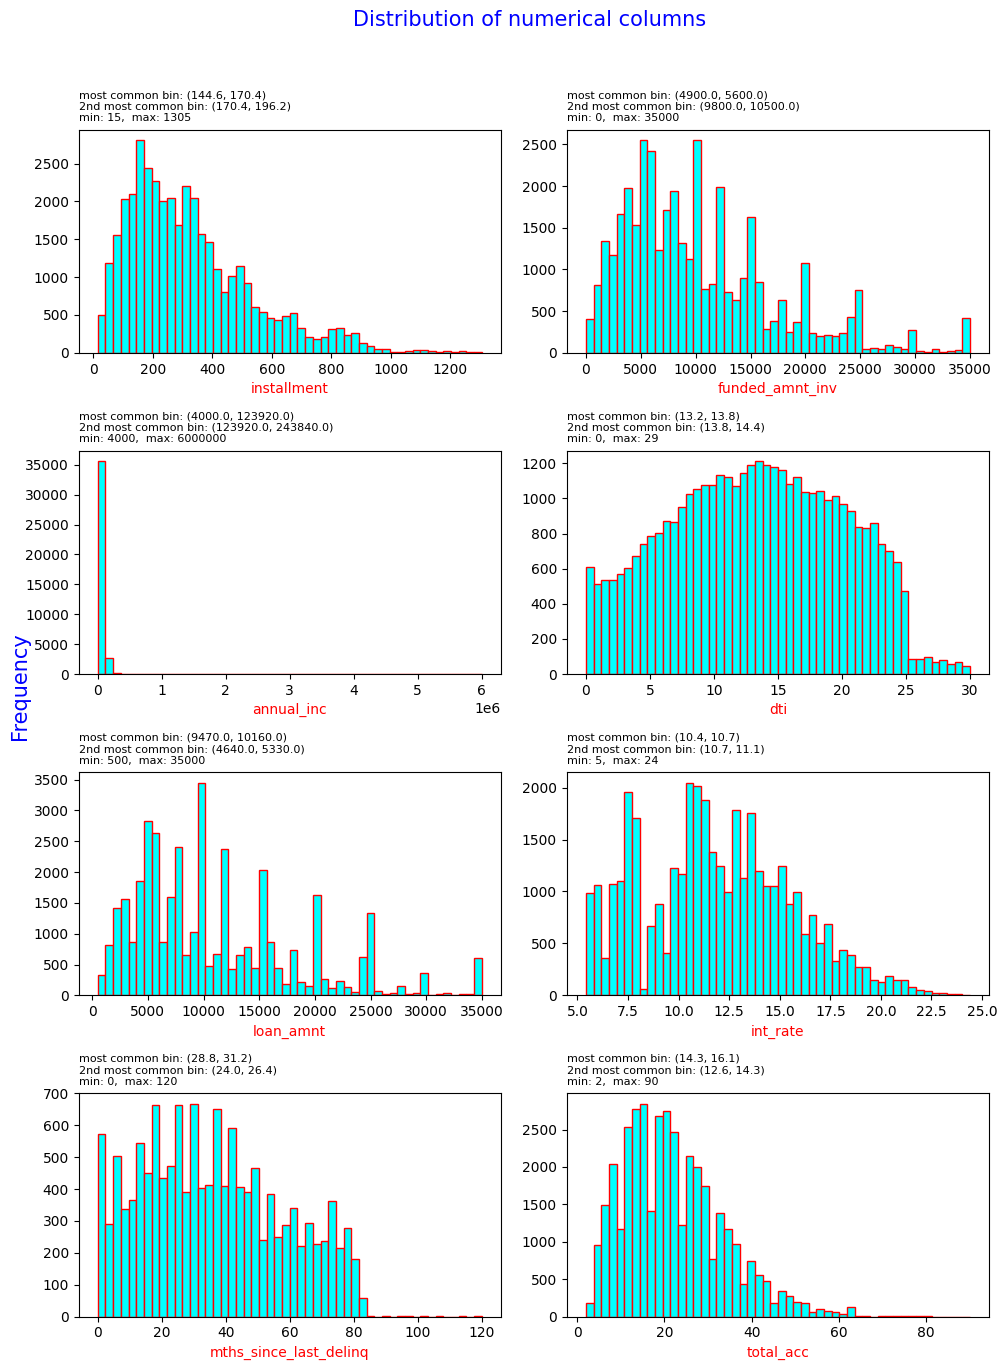

In [37]:
plot_multiple_histograms_univar(loans_defaults_or_paid, top_8_numerical.index.to_numpy())

- `Interpretations from the above histograms`


  - The visuals display the min and max values for each variable as well as the most common bins, or places where the majority of similar values fall.

  - The variables contain a few extreme values that contribute to the outliers. 

  - The majority of borrower **installments** have a value of less than 400.

  - **funded_amnt_inv** - The majority of applicants are granted loan between 4,500 and 10,000.

  - **dti** ratio varies extensively between 0 to 25. Lender tend to take risks by giving loans to clients with higher debt to income levels.

  - Most of the borrowers ask for a **loan_amount** of 5000 or 10000 approximately

  - Usually, **int_rate** is offered in the range of 6-8% or 10-15%. May be the case that the interest rate is higher for the borrowers with higher debt-to-income ratios. Perhaps the interest rate fluctuates periodically depending on the purpose of loan.

  - **mths_since_last_delinq** - The majority of borrowers' most recent delinquency falls within a wide range of 0 to 50 months, indicating that the lender is taking slighlty lower risk by approving borrowers whose prior delinquency have happened considerably earlier.

  - **total_acc** (total number of credit lines) - The majority of borrowers have between 10 and 30 credit lines total. 

5) Histogran to visualize the distribution of <span style="color:green">annual_inc</span> column

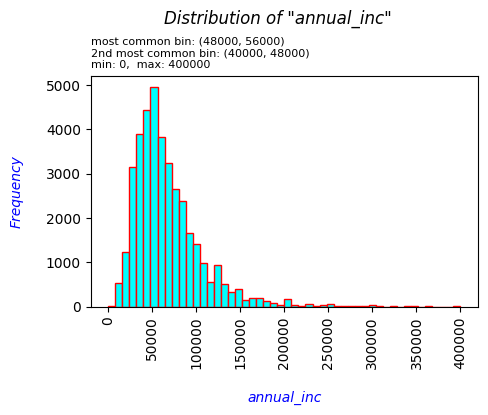

In [38]:
fig = plt.figure()
fig.set_size_inches(5, 3)
ax = plt.subplot(111)
num, bins, _ = ax.hist(loans_defaults_or_paid.annual_inc, bins=50, range=(0, 400000), color='cyan', edgecolor='red')
sorted_bins = sorted(zip(num.astype(int), zip(bins[:-1].astype(int), bins[1:].astype(int))),
                                     key=lambda x:x[0],
                                     reverse=True)
ax.set_title(f'most common bin: {sorted_bins[0][1]} \n2nd most common bin: {sorted_bins[1][1]} \nmin: {bins.min().astype(int)},  max: {bins.max().astype(int)}',
                                               fontsize=8, fontweight=30, color='black', loc='left')
plt.xticks(rotation=90)
ax.set_xlabel('\nannual_inc', fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='oblique'))
ax.set_ylabel('Frequency\n', fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='oblique'))
fig.suptitle('Distribution of "annual_inc"\n', color='black', fontstyle='oblique', y=1.1)
plt.show()


- `Interpretation of the above plot`


  - **annual_inc** has many extreme values which are far away from the majority of the ditribution and hence it is ***heavily skewed***, indicating the presence of outliers.
  - Most of the debtors make between 25,000 and 85,000 annually. The lender appears to get loan requests from low salaried individuals.

6) Histogran to visualize the distribution of <span style="color:green">open_acc</span> column

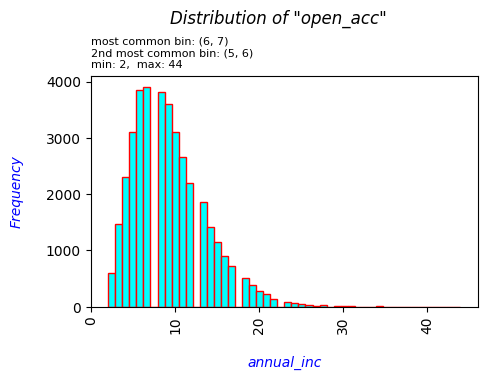

In [39]:
fig = plt.figure()
fig.set_size_inches(5, 3)
ax = plt.subplot(111)
num, bins, _ = ax.hist(loans_defaults_or_paid.open_acc, bins=50, color='cyan', edgecolor='red')
sorted_bins = sorted(zip(num.astype(int), zip(bins[:-1].astype(int), bins[1:].astype(int))),
                                     key=lambda x:x[0],
                                     reverse=True)
ax.set_title(f'most common bin: {sorted_bins[0][1]} \n2nd most common bin: {sorted_bins[1][1]} \nmin: {bins.min().astype(int)},  max: {bins.max().astype(int)}',
                                               fontsize=8, fontweight=30, color='black', loc='left')
plt.xticks(rotation=90)
ax.set_xlabel('\nannual_inc', fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='oblique'))
ax.set_ylabel('Frequency\n', fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='oblique'))
fig.suptitle('Distribution of "open_acc"\n', color='black', fontstyle='oblique', y=1.1)
plt.show()


- `Interpretation of the above plot`


  - **open_acc** (number of open credit lines) - Majority of the borrowers have between 5-10 open credit lines, indicating that the lender is cautious to approve loan requests from applicants who have higher number of active loan accounts


#### Detect and Treat Outliers

***Let's impute the outliers as missing values for this case study.*** 
- Later we can decide how to remove these outliers before feeding the data to the model
<br>
<br>
__Strategy to detect outliers:__
Detecting outliers on the basis of the interquartile difference (q3-q1), may lead to removing large number of them, losing vital information from the dataset. Instead, determine the growth percentage of the consecutive quantiles to detect outliers. 
  - **Examples**:
    - if 100th percentile value is much higher than 99th percentile value, then 100th percentile value is an outlier. 
    - We can also compare the rate at which the values grow at the lower percentiles with those in the higher percentiles and if the higher percentile values grow much more than the lower percentile values, it will indicate presence of outliers

In [40]:
def detect_and_treat_outliers(dframe, 
                              numerical_column_name, 
                              treat_outliers_flag:bool=False,
                              commit_change:bool=False, 
                              lower_index:int=0, 
                              higher_index:int=99):
    '''
    Calculate the growth rate between the consecutive percentile quantities to determine outliers. 
    Once detected, inpute them with missing values

    Params:
      dframe: A datafrmae to access
      numerical_column_name: Name of a numerical column in the dataframe
      treat_outliers_flag: 
         Default to False, will return the growth rate between the consecutive percentile values.
         Setting to True, will return the specified column with values bounded within the desired quantiles.
      commit_change:
         Default to False, (same as treat_outliers_flag==True) 
         Setting to True, will impute the outliers as missing values
      lower_index: an interger to determine the lower bound quantile
      higher_index: an interger to determine the upper bound quantile
    
    Returns:
       A dataframe w.r.t. the state of the treat_outliers_flag variable.
    '''
    if not isinstance(numerical_column_name, str):
        raise TypeError('Arg "numerical_column_name" must be a str.')
    if not isinstance(treat_outliers_flag, bool) and not isinstance(commit_change, bool):
        raise TypeError('Arg(s) "treat_outliers_flag" & "commit_change" must be of bool types.')
    if not isinstance(lower_index, int) and not isinstance(higher_index, int):
        raise TypeError('Arg(s) passed to "lower_index" & "higher_index" must be of int types.')
    if isinstance(dframe, pd.DataFrame):
        try:
            quantile_values = np.percentile(dframe[numerical_column_name].dropna(), range(0, 101))
            if not treat_outliers_flag:
                percentile_growth = np.ediff1d(quantile_values, to_end=0)
                percentile_growth = np.divide(percentile_growth,
                                              quantile_values,
                                              where=quantile_values!=0)
                # print(quantile_values[95])
                return pd.DataFrame({'growth_rate': percentile_growth*100,
                                     'consecutive-percentiles':[f'{x-1}, {x}' for x in range(1, 101)]+[f'100, NA']})[-1::-1]
            else:
                lower_bound = quantile_values[lower_index]
                upper_bound = quantile_values[higher_index]
                # print(upper_bound)
                if commit_change:
                    filter_cond_commit = (dframe[numerical_column_name] < lower_bound) | (dframe[numerical_column_name] > upper_bound)
                    dframe[numerical_column_name][filter_cond_commit] = np.nan
                else:
                    filter_cond_chk = (dframe[numerical_column_name] > lower_bound) & (dframe[numerical_column_name] < upper_bound)
                    return dframe[numerical_column_name][filter_cond_chk]
        except Exception as e:
            raise e
    else:
        raise TypeError('Arg "dframe" mmust be a pd.DataFrame object.')

1) **annual_inc** - impute the outliers with missing values

>> Detect the outliers in `annual_inc`

In [41]:
detect_and_treat_outliers(loans_defaults_or_paid, numerical_column_name='annual_inc', treat_outliers_flag=False).head(20)

,growth_rate,consecutive-percentiles
100,0.000,"100, NA"
99,2462.526,"99, 100"
98,25.211,"98, 99"
97,13.333,"97, 98"
96,10.000,"96, 97"
95,7.140,"95, 96"
94,4.481,"94, 95"
93,5.098,"93, 94"
92,4.508,"92, 93"
91,1.667,"91, 92"


>> Verify the column `annual_inc` after imputing its outliers with missing values. 
<br>
**Change will not be committed yet.**
<br>
Use histplots and boxplots to confirm

In [42]:
check_annual_inc = detect_and_treat_outliers(loans_defaults_or_paid, 
                                             numerical_column_name='annual_inc',
                                             treat_outliers_flag=True, 
                                             commit_change=False,
                                             lower_index=5,
                                             higher_index=95)
check_annual_inc.shape

(34456,)

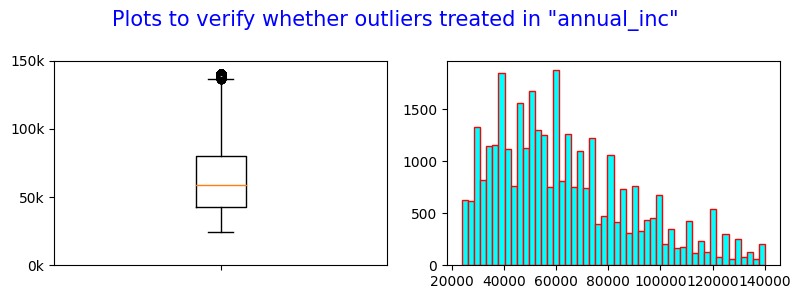

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(8, 3)
col_name_notna = check_annual_inc
ax[0].boxplot(col_name_notna)
ax[1].hist(col_name_notna, bins=50, edgecolor='red', color='cyan')
ax[0].set_xticks(labels=[''], ticks=[1])
fig.suptitle('Plots to verify whether outliers treated in "annual_inc"', fontsize=15, color='blue')
ticks = np.arange(0, 200000, 50000)
ax[0].set_yticks(ticks=ticks, labels=[f'{i//1000}k' for i in ticks])
fig.tight_layout()
fig.show()

>> Finally treat the outliers in `annual_inc` as missing values and commit the change.

In [44]:
detect_and_treat_outliers(loans_defaults_or_paid,
                          numerical_column_name='annual_inc',
                          treat_outliers_flag=True,
                          commit_change=True,
                          lower_index=5,
                          higher_index=95)

>> Same strategy will be followed for all other facutual variables of interest having outliers as shown below

2) **funded_amnt_inv** - impute the outliers with missing values

In [45]:
detect_and_treat_outliers(loans_defaults_or_paid, numerical_column_name='funded_amnt_inv', treat_outliers_flag=False).tail(20)

,growth_rate,consecutive-percentiles
19,6.586,"19, 20"
18,2.617,"18, 19"
17,0.000,"17, 18"
16,4.575,"16, 17"
15,6.250,"15, 16"
14,3.597,"14, 15"
13,8.594,"13, 14"
12,6.667,"12, 13"
11,0.000,"11, 12"
10,6.195,"10, 11"


(33558,)


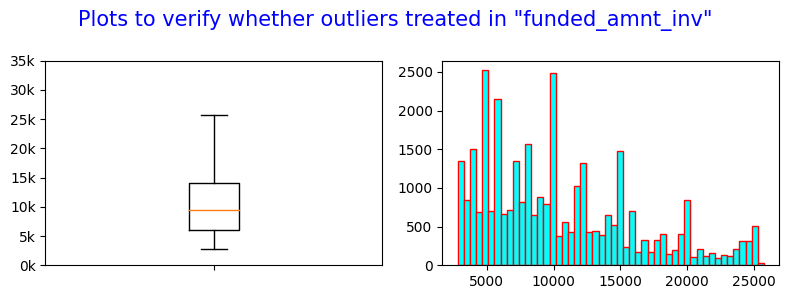

In [46]:
check_funded_amnt_inv = detect_and_treat_outliers(loans_defaults_or_paid, 
                                             numerical_column_name='funded_amnt_inv',
                                             treat_outliers_flag=True, 
                                             commit_change=False,
                                             lower_index=10,
                                             higher_index=97)

print(check_funded_amnt_inv.shape)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(8, 3)
col_name_notna = check_funded_amnt_inv
ax[0].boxplot(col_name_notna)
ax[1].hist(col_name_notna, bins=50, edgecolor='red', color='cyan')
ax[0].set_xticks(labels=[''], ticks=[1])
fig.suptitle('Plots to verify whether outliers treated in "funded_amnt_inv"', fontsize=15, color='blue')
ticks = np.arange(0, 40000, 5000)
ax[0].set_yticks(ticks=ticks, labels=[f'{i//1000}k' for i in ticks])
fig.tight_layout()
fig.show()

In [47]:
detect_and_treat_outliers(loans_defaults_or_paid,
                          numerical_column_name='funded_amnt_inv',
                          treat_outliers_flag=True,
                          commit_change=True,
                          lower_index=10,
                          higher_index=95)

3) **loan_amnt** - impute the outliers with missing values

In [48]:
detect_and_treat_outliers(loans_defaults_or_paid, numerical_column_name='loan_amnt', treat_outliers_flag=False).tail(30)

,growth_rate,consecutive-percentiles
29,0.000,"29, 30"
28,0.000,"28, 29"
27,0.000,"27, 28"
26,8.597,"26, 27"
25,4.245,"25, 26"
24,6.000,"24, 25"
23,0.000,"23, 24"
22,0.000,"22, 23"
21,0.000,"21, 22"
20,0.000,"20, 21"


(33681,)


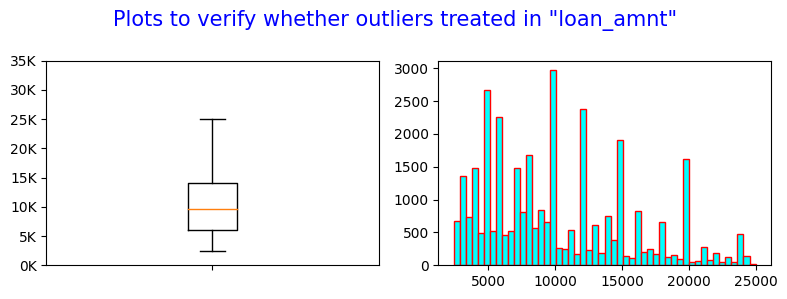

In [49]:
check_loan_amnt = detect_and_treat_outliers(loans_defaults_or_paid, 
                                             numerical_column_name='loan_amnt',
                                             treat_outliers_flag=True, 
                                             commit_change=False,
                                             lower_index=5,
                                             higher_index=96)

print(check_loan_amnt.shape)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(8, 3)
col_name_notna = check_loan_amnt
ax[0].boxplot(col_name_notna)
ax[1].hist(col_name_notna, bins=50, edgecolor='red', color='cyan')
ax[0].set_xticks(labels=[''], ticks=[1])
fig.suptitle('Plots to verify whether outliers treated in "loan_amnt"', fontsize=15, color='blue')
ticks = np.arange(0, 40000, 5000)
ax[0].set_yticks(ticks=ticks, labels=[f'{i//1000}K' for i in ticks])
fig.tight_layout()
fig.show()

In [50]:
detect_and_treat_outliers(loans_defaults_or_paid,
                          numerical_column_name='loan_amnt',
                          treat_outliers_flag=True,
                          commit_change=True,
                          lower_index=5,
                          higher_index=96)

4) **installment** - impute the outliers with missing values

In [51]:
detect_and_treat_outliers(loans_defaults_or_paid, numerical_column_name='installment', treat_outliers_flag=False).tail(20)

,growth_rate,consecutive-percentiles
19,4.534,"19, 20"
18,4.105,"18, 19"
17,3.380,"17, 18"
16,3.246,"16, 17"
15,3.746,"15, 16"
14,3.125,"14, 15"
13,5.298,"13, 14"
12,5.514,"12, 13"
11,5.498,"11, 12"
10,3.974,"10, 11"


(35873,)


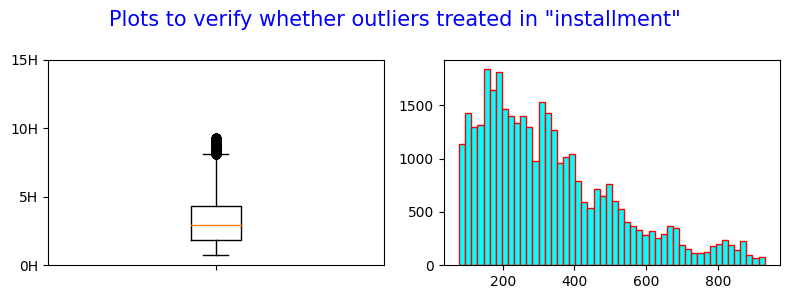

In [52]:
check_installment = detect_and_treat_outliers(loans_defaults_or_paid, 
                                             numerical_column_name='installment',
                                             treat_outliers_flag=True, 
                                             commit_change=False,
                                             lower_index=6,
                                             higher_index=99)

print(check_installment.shape)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(8, 3)
col_name_notna = check_installment
ax[0].boxplot(col_name_notna)
ax[1].hist(col_name_notna, bins=50, edgecolor='red', color='cyan')
ax[0].set_xticks(labels=[''], ticks=[1])
fig.suptitle('Plots to verify whether outliers treated in "installment"', fontsize=15, color='blue')
ticks = np.arange(0, 2000, 500)
ax[0].set_yticks(ticks=ticks, labels=[f'{i//100}H' for i in ticks])
fig.tight_layout()
fig.show()

In [53]:
detect_and_treat_outliers(loans_defaults_or_paid,
                          numerical_column_name='installment',
                          treat_outliers_flag=True,
                          commit_change=True,
                          lower_index=6,
                          higher_index=99)

5) **int_rate** - impute the outliers with missing values

In [54]:
detect_and_treat_outliers(loans_defaults_or_paid, numerical_column_name='int_rate', treat_outliers_flag=False).tail(20)

,growth_rate,consecutive-percentiles
19,0.254,"19, 20"
18,0.000,"18, 19"
17,1.809,"17, 18"
16,1.044,"16, 17"
15,1.997,"15, 16"
14,0.000,"14, 15"
13,0.267,"13, 14"
12,1.216,"12, 13"
11,1.509,"11, 12"
10,2.101,"10, 11"


(37617,)


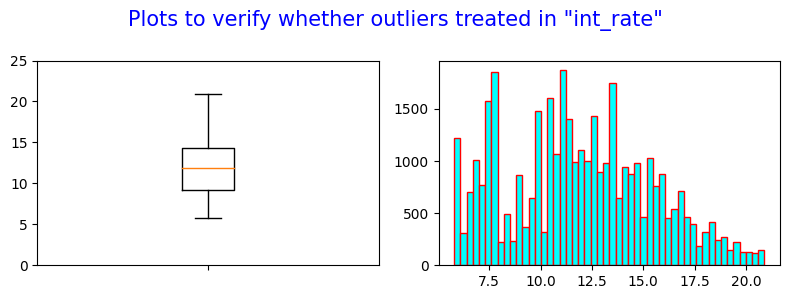

In [55]:
check_int_rate = detect_and_treat_outliers(loans_defaults_or_paid, 
                                             numerical_column_name='int_rate',
                                             treat_outliers_flag=True, 
                                             commit_change=False,
                                             lower_index=0,
                                             higher_index=99)

print(check_int_rate.shape)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(8, 3)
col_name_notna = check_int_rate
ax[0].boxplot(col_name_notna)
ax[1].hist(col_name_notna, bins=50, edgecolor='red', color='cyan')
ax[0].set_xticks(labels=[''], ticks=[1])
fig.suptitle('Plots to verify whether outliers treated in "int_rate"', fontsize=15, color='blue')
ticks = np.arange(0, 30, 5)
ax[0].set_yticks(ticks=ticks, labels=[f'{i}' for i in ticks])
fig.tight_layout()
fig.show()

In [56]:
detect_and_treat_outliers(loans_defaults_or_paid,
                          numerical_column_name='int_rate',
                          treat_outliers_flag=True,
                          commit_change=True,
                          lower_index=0,
                          higher_index=99)

5) **total_acc** - impute the outliers with missing values

In [57]:
detect_and_treat_outliers(loans_defaults_or_paid, numerical_column_name='total_acc', treat_outliers_flag=False).head(20)

,growth_rate,consecutive-percentiles
100,0.000,"100, NA"
99,60.714,"99, 100"
98,9.804,"98, 99"
97,6.250,"97, 98"
96,6.667,"96, 97"
95,4.651,"95, 96"
94,2.381,"94, 95"
93,2.439,"93, 94"
92,5.128,"92, 93"
91,2.632,"91, 92"


(35553,)


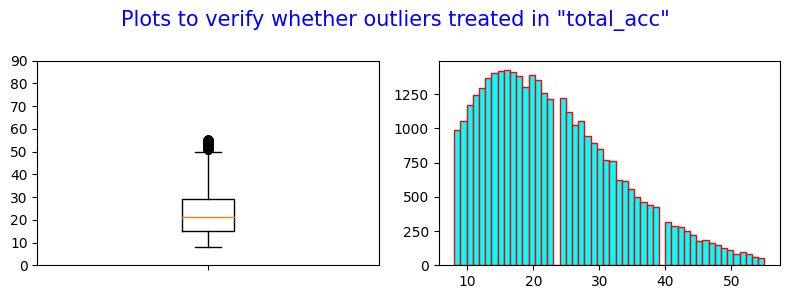

In [58]:
check_total_acc = detect_and_treat_outliers(loans_defaults_or_paid, 
                                             numerical_column_name='total_acc',
                                             treat_outliers_flag=True, 
                                             commit_change=False,
                                             lower_index=5,
                                             higher_index=99)

print(check_total_acc.shape)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(8, 3)
col_name_notna = check_total_acc
ax[0].boxplot(col_name_notna)
ax[1].hist(col_name_notna, bins=50, edgecolor='red', color='cyan')
ax[0].set_xticks(labels=[''], ticks=[1])
fig.suptitle('Plots to verify whether outliers treated in "total_acc"', fontsize=15, color='blue')
ticks = np.arange(0, 100, 10)
ax[0].set_yticks(ticks=ticks, labels=[f'{i}' for i in ticks])
fig.tight_layout()
fig.show()

In [59]:
detect_and_treat_outliers(loans_defaults_or_paid,
                          numerical_column_name='total_acc',
                          treat_outliers_flag=True,
                          commit_change=True,
                          lower_index=5,
                          higher_index=99)

6) **mths_since_last_delinq** - impute the outliers with missing values

In [60]:
detect_and_treat_outliers(loans_defaults_or_paid, numerical_column_name='mths_since_last_delinq', treat_outliers_flag=False).tail(20)

,growth_rate,consecutive-percentiles
19,7.143,"19, 20"
18,0.000,"18, 19"
17,7.692,"17, 18"
16,8.333,"16, 17"
15,9.091,"15, 16"
14,0.000,"14, 15"
13,10.000,"13, 14"
12,11.111,"12, 13"
11,12.500,"11, 12"
10,12.676,"10, 11"


(12143,)


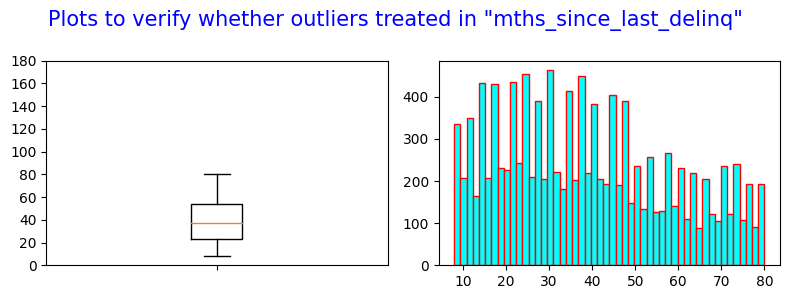

In [61]:
check_mths_since_last_delinq = detect_and_treat_outliers(loans_defaults_or_paid, 
                                             numerical_column_name='mths_since_last_delinq',
                                             treat_outliers_flag=True, 
                                             commit_change=False,
                                             lower_index=9,
                                             higher_index=99)

print(check_mths_since_last_delinq.shape)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(8, 3)
col_name_notna = check_mths_since_last_delinq
ax[0].boxplot(col_name_notna)
ax[1].hist(col_name_notna, bins=50, edgecolor='red', color='cyan')
ax[0].set_xticks(labels=[''], ticks=[1])
fig.suptitle('Plots to verify whether outliers treated in "mths_since_last_delinq"', fontsize=15, color='blue')
ticks = np.arange(0, 200, 20)
ax[0].set_yticks(ticks=ticks, labels=[f'{i}' for i in ticks])
fig.tight_layout()
fig.show()

In [62]:
detect_and_treat_outliers(loans_defaults_or_paid,
                          numerical_column_name='mths_since_last_delinq',
                          treat_outliers_flag=True,
                          commit_change=True,
                          lower_index=9,
                          higher_index=99)

#### **Univariate Analysis on Categorical Variables** <br>** (including few numerical coulmns used as ordered categorical variables)

- Create a function to visualize bar plots for univariate analysis on categorical variables

In [63]:
def create_bar_plots_univar(dframe, colname, W, H, width,
                            rotate:bool=False,
                            annotate_flag:bool=True,
                            convert_to_str:bool=False):
    '''
    Create bar plots for univariate analysis
    
    Params:
       dframe: A dataframe to read
       colname: Name of the column to access in the dataframe
       W: A number to set the width of the plot
       H: A number to set the height of the plot
       width: A number to set the width of the bars in the plot
       rotate: Setting to True, will rotate the xticks
       annotate_flag: Default to True, will add annotations to the plot
    '''
    try:
        fig = plt.figure()
        ax = plt.subplot()
        fig.set_size_inches(w=W, h=H)
        freq = dframe[colname].value_counts()
        rand_colors = np.random.choice(['yellow', 'pink', 'cyan'],
                                        1,
                                        replace=False)
        if convert_to_str:
            freq.index = freq.index.astype(str)
        ax.bar(x=freq.index, height=freq, width=width, edgecolor='red', align='center', color=rand_colors)
        ax.set_ylabel('count', fontdict=dict(fontsize=11, fontweight=20, color='green', fontstyle='oblique'))
        ax.set_title(f'{colname}',
                         fontdict=dict(fontsize=12, fontweight=20, color='blue', fontstyle='oblique'))
        if rotate:
            plt.xticks(rotation=90)
        if annotate_flag:
            for i in zip(freq.index, freq):
                ax.annotate(xy=i, text=f'{round(i[1]/freq.sum()*100, 1)}%', horizontalalignment='left', verticalalignment='bottom')
        fig.show()
    except Exception as e:
        raise

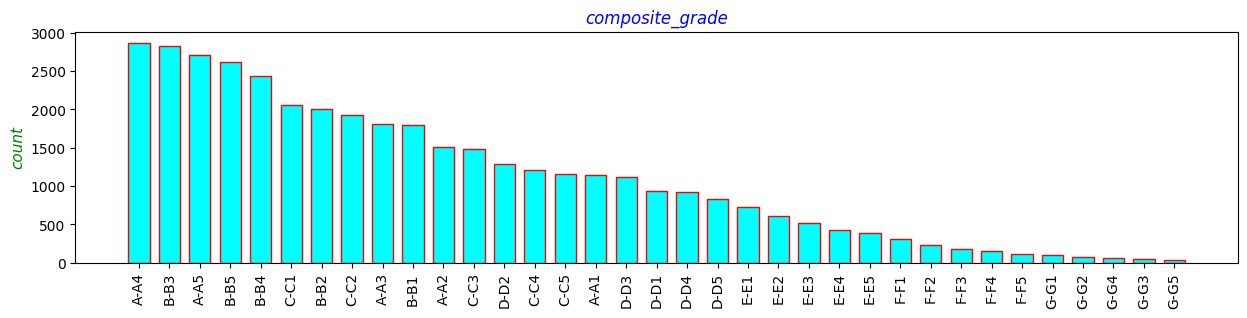

In [64]:
create_bar_plots_univar(loans_defaults_or_paid, 'composite_grade', W=15, H=3, width=.7, annotate_flag=False, rotate=True)

- `Interpretation from the above plot`


  - Majority of the borrowers have composite grades as **A-A4**, **B-B3** and **A-A5**. Higher graded applicants are more likely to get loans from the lender
  

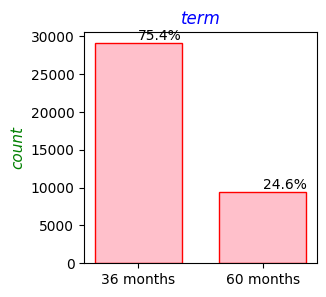

In [65]:
create_bar_plots_univar(loans_defaults_or_paid, 'term', W=3, H=3, width=.7)

- `Interpretation from the above plot`


  - The maximum number of loans has a 36-month loan tenure (around 75%), which is more than twice as many as loans with a 60-month tenure. 

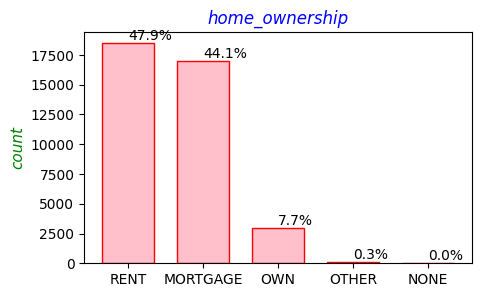

In [66]:
create_bar_plots_univar(loans_defaults_or_paid, 'home_ownership', W=5, H=3, width=.7)

- `Interpretation from the above plot`


  - Most of the debtors have mortgaged properties or rented homes. The borrowers who do not currently own a home appear to be renting, and they are probably going to want one of their own in the future and will take on a mortgage against it. <br>Therefore, loans for mortgage properties are as higher among the borrowers as the renters

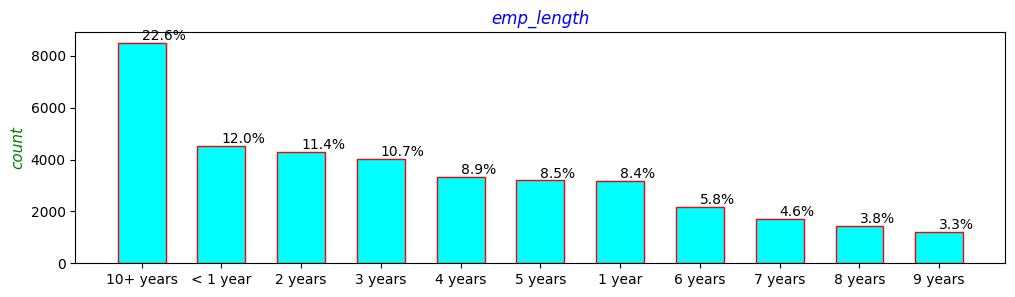

In [67]:
create_bar_plots_univar(loans_defaults_or_paid, 'emp_length', W=12, H=3, width=.6)

- `Interpretation from the above plot`


  - Most of the loan takers have an employment experience of **10+ years** (nearly twice the number of the second most popular category **<1 year**).
  - This shows that the lender is likely to approve loan requests from professionals who have better income than others, as they have more than 10 years of experience, lowering the risk of financial loss to the company.

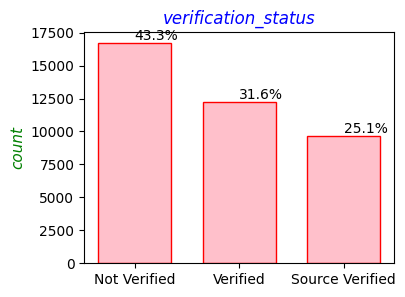

In [68]:
create_bar_plots_univar(loans_defaults_or_paid, 'verification_status', W=4, H=3, width=.7)

- `Interpretation from the above plot`


  - Most of the borrowers are not verfied. 
  - Lender is taking high risk by lending to borrowers who are not verified.

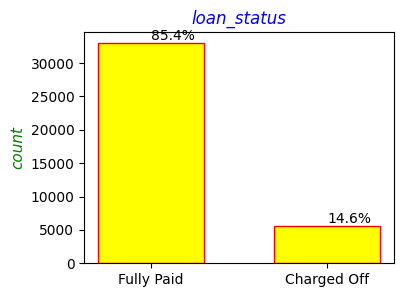

In [69]:
create_bar_plots_univar(loans_defaults_or_paid, 'loan_status', W=4, H=3, width=.6)

- `Interpretation from the above plot`


  - The number of fully paid loans exceeds the number of charged-off loans by nearly six times.

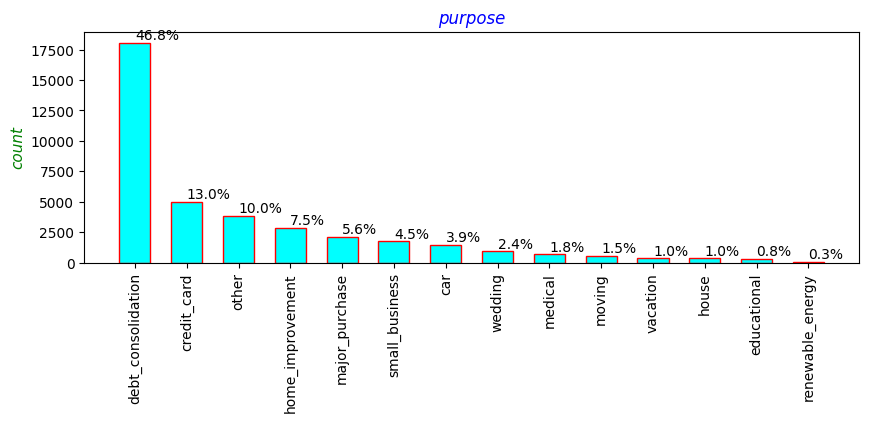

In [70]:
create_bar_plots_univar(loans_defaults_or_paid, 'purpose', W=10, H=3, width=.6, rotate=True)

- `Interpretation from the above plot`


  - Among the loan accounts, the primary purpose is debt consolidation, which is contributing nearly 47% of the all the loan purposes, followed by credit card, which contributes to only 13%. Lender is taking high risk by approving loan for debt consolidation.

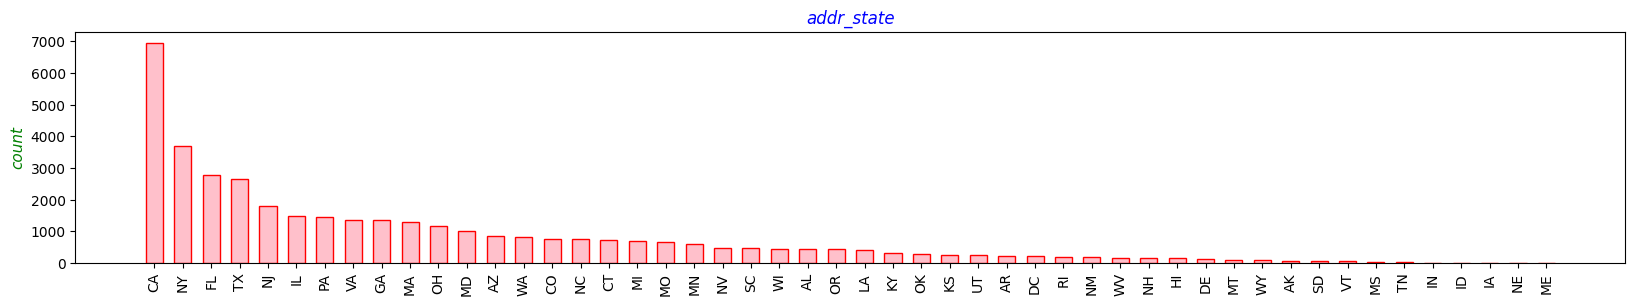

In [71]:
create_bar_plots_univar(loans_defaults_or_paid, 'addr_state', W=20, H=3, width=.6, rotate=True, annotate_flag=False)

- `Interpretation from the above plot`


  - Most of the borrowers are from the state California, followed by New York, Florida and Texas states.

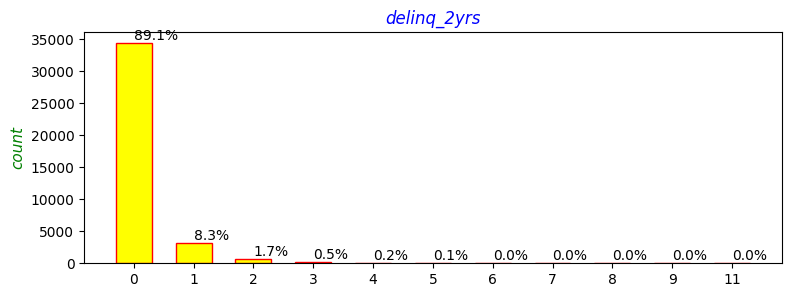

In [72]:
create_bar_plots_univar(loans_defaults_or_paid, 'delinq_2yrs', W=9, H=3, width=.6, convert_to_str=True)

- `Interpretation from the above plot`

  - Around 90% of the borrowers have not miss their repayments in the last two years. Lender ensures lower risk of default

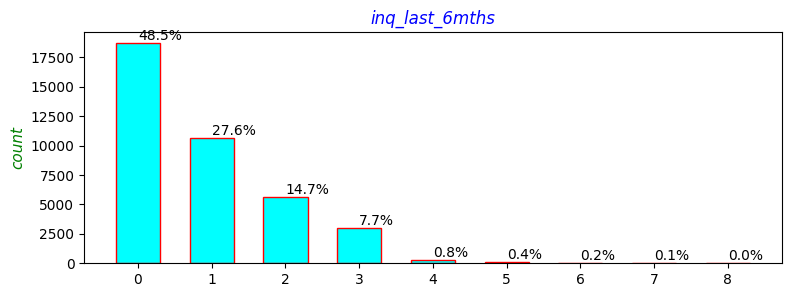

In [73]:
create_bar_plots_univar(loans_defaults_or_paid, 'inq_last_6mths', W=9, H=3, width=.6, convert_to_str=True)

- `Interpretation from above plot`

  - Borrowers who tend to apply for loans more frequently are also less likely to get approved for loans.

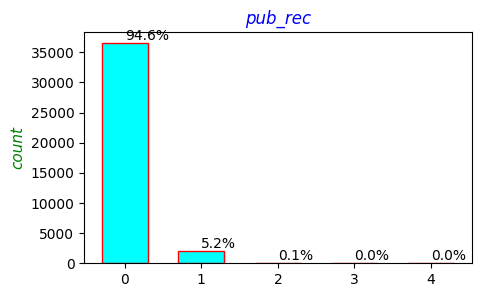

In [74]:
create_bar_plots_univar(loans_defaults_or_paid, 'pub_rec', W=5, H=3, width=.6, convert_to_str=True)

- `Interpretation from above plot`

  - Less publicly available negative history makes an applicant more likely to be approved for a loan from the lender.

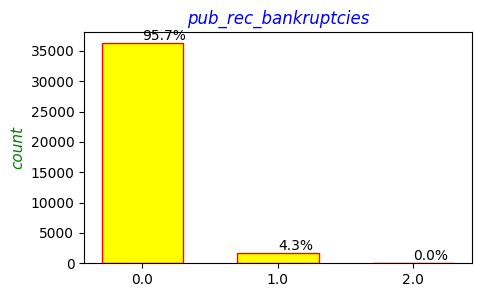

In [75]:
create_bar_plots_univar(loans_defaults_or_paid, 'pub_rec_bankruptcies', W=5, H=3, width=.6, convert_to_str=True)

- `Interpretation from above plot`

  - Approximately 95% of the borrowers have never filed for bankruptcy, making them a desirable option for the lender.

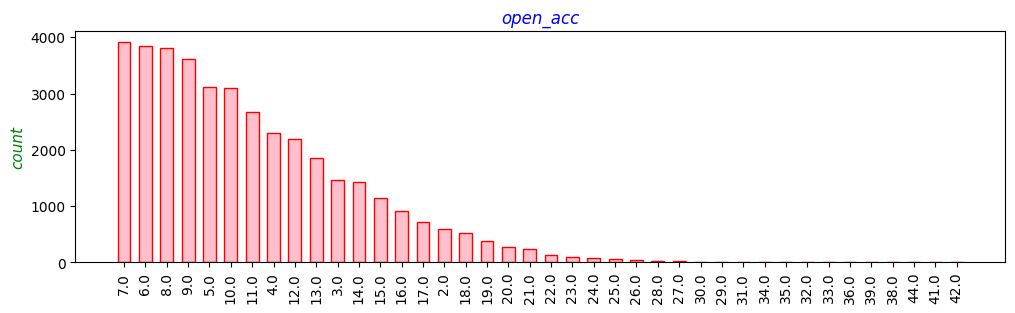

In [76]:
create_bar_plots_univar(loans_defaults_or_paid, 'open_acc', W=12, H=3, width=.6, convert_to_str=True, annotate_flag=False, rotate=True)

- `Interpretation from the above plot`

  - Most of the borrowers have less number of open credit lines.

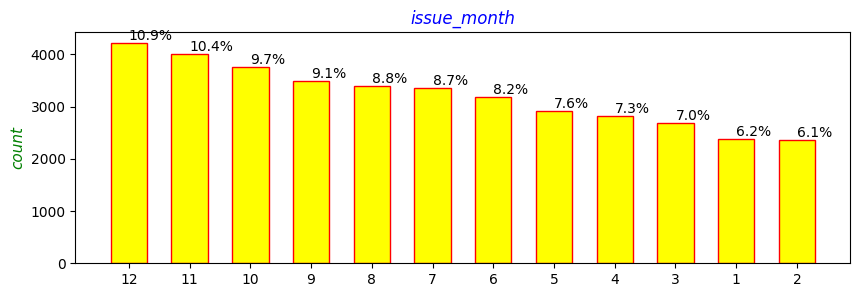

In [77]:
create_bar_plots_univar(loans_defaults_or_paid, 'issue_month', W=10, H=3, width=.6, convert_to_str=True, annotate_flag=True)

- `Interpretation from the above plot`

  - December sees the highest number of loans, followed by November and so forth.

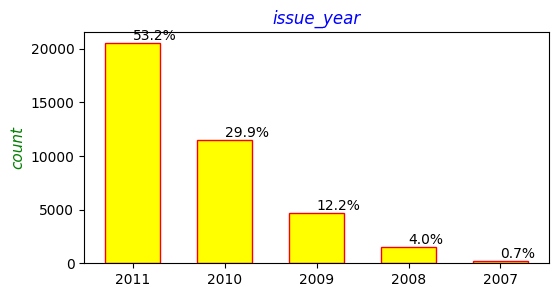

In [78]:
create_bar_plots_univar(loans_defaults_or_paid, 'issue_year', W=6, H=3, width=.6, convert_to_str=True, annotate_flag=True)

- `Interpretation from the above plot`

  - More than half of the loans were issued by the company in 2011. Looking at the trend over time, it appears that the company has been reducing its lending operations.

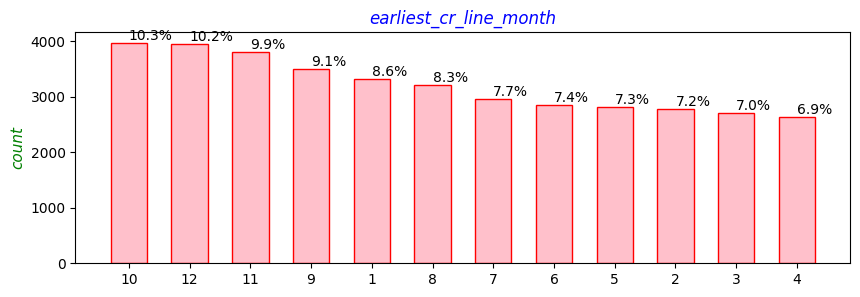

In [79]:
create_bar_plots_univar(loans_defaults_or_paid, 'earliest_cr_line_month', W=10, H=3, width=.6, convert_to_str=True, annotate_flag=True)

- `Interpretation from the above plot`  
  
  - The longer it has been since the last credit line was opened, the more likely the borrower will receive the loan. It appears the lender grants loans to customers who avoid taking loans too often.

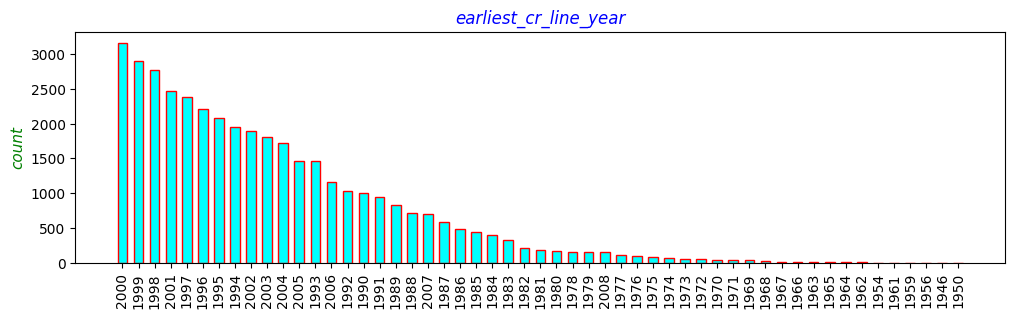

In [80]:
create_bar_plots_univar(loans_defaults_or_paid, 'earliest_cr_line_year', W=12, H=3, width=.6,
                        convert_to_str=True, annotate_flag=False, rotate=True)

- `Interpretation from the above plot`  
  
  - It is less common for borrowers with very old credit histories, such as those from 1950 or 1961, to apply for new loans. Most of the borrowers have their last credit line opened in 90s or 2000s.

#### **Segmented Univariate Analysis to assess the influence of Numerical Variables on Loan Statuses**

1) `dti` - Debt-to-income ratio

In [81]:
loans_defaults_or_paid.groupby('loan_status', as_index=True)['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5627.000,14.001,6.586,0.000,9.050,14.290,19.290,29.850
Fully Paid,32950.000,13.148,6.680,0.000,7.980,13.200,18.390,29.990


- **Interpretations**


  - The `dti` average of the loan defaulters is not significantly different than that of the borrowers who have already paid in full. <br>The quantiles (q1, q2, q3) rarely differ among the loan statuses due to the variation in the debt-to-income ratio, suggesting that the small difference in the mean is due to randomness.

  - We may require to perform hypothesis testing to ascertain that the small difference is mean is not due to randomness and is statiscally significant. 

  - But still, the difference in mean indicates that the borrowers who are defaulted are more likely to have higher debt to income ratio, may be because they earn less income and so, are failing to repay the debts. 

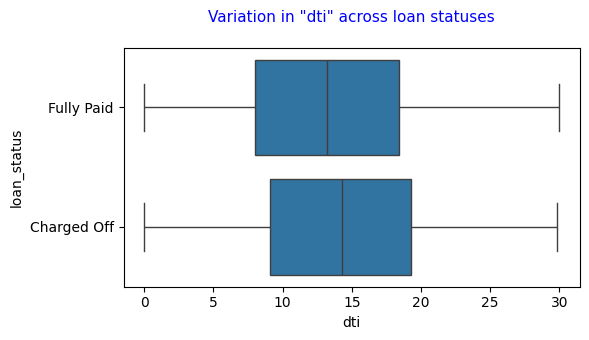

In [82]:
# Let's plot the dti across each of the loan statuses
fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(6, 3.5)
sns.boxplot(data=loans_defaults_or_paid,x='dti',y='loan_status')
ax.set_title('Variation in "dti" across loan statuses\n', fontsize=11, color='blue', fontstyle='normal')
fig.tight_layout()
fig.show()

- **Interpretations from the above plot**

  - The 25th and 75th percentile values of `dti` are slightly higher for charged-off loan accounts, compared to the ones which are paid in full.  
  
  - But, there is no significant difference in the amount of variation explained by debt-to-income ratios across the loan statuses. <br>We can say that the ***dti*** is less likely to influence the decision of whether the loan application can be accepted or rejected.

2) `int_rate`

In [83]:
loans_defaults_or_paid.groupby('loan_status', as_index=True)['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5478.000,13.597,3.438,5.420,11.140,13.490,16.080,20.990
Fully Paid,32758.000,11.549,3.521,5.420,8.490,11.490,13.980,20.990


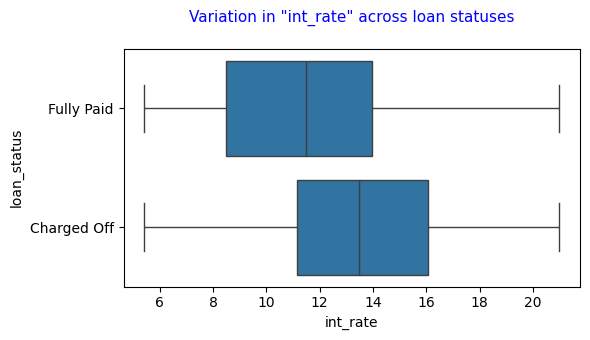

In [84]:
# Let's plot the int_rate across each of the loan statuses
fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(6, 3.5)
sns.boxplot(data=loans_defaults_or_paid,x='int_rate',y='loan_status')
ax.set_title('Variation in "int_rate" across loan statuses\n', fontsize=11, color='blue', fontstyle='normal')
fig.tight_layout()
fig.show()

- **Interpretations**


  - The interest rates of fully paid loans and defaulted loans differ noticeably, with the defaulted loan interest rate being greater on average. The riskier the borrower, the higher the loan interest rate.

  - ***int_rate*** is likely to influence the loan status of the borrower. Thus, it is a driving factor behind loan default

3) `funded_amnt_inv`

In [85]:
loans_defaults_or_paid.groupby('loan_status', as_index=True)['funded_amnt_inv'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,4643.000,10650.139,5586.489,2825.000,5975.000,9856.178,14900.000,24500.000
Fully Paid,28152.000,10045.289,5249.696,2825.000,5900.000,9050.000,13500.000,24500.000


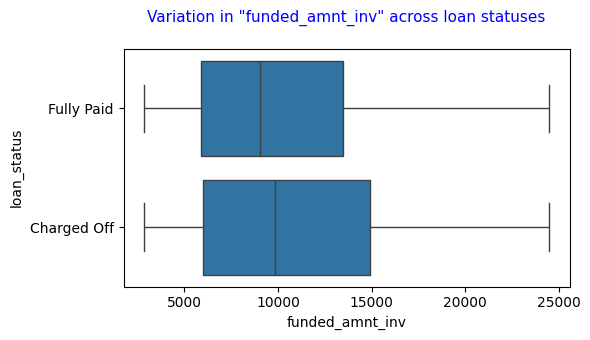

In [86]:
# Let's plot the funded_amnt_inv across each of the loan statuses
fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(6, 3.5)
sns.boxplot(data=loans_defaults_or_paid,x='funded_amnt_inv',y='loan_status')
ax.set_title('Variation in "funded_amnt_inv" across loan statuses\n', fontsize=11, color='blue', fontstyle='normal')
fig.tight_layout()
fig.show()

- **Interpretations**

  - The 75th percentile value of the funded amount from investors is higher in the defaulted loans compared to the loans which are already paid in full. But the same difference cannot be observed with median or 25th percentile values across the loan statuses. <br>This shows that large amount of loans are more likely to default. 
  
  - Hence, `funded_amnt_inv` seems to have a moderate impact on the loan statuses of the borrowers and  may be useful in determining whether a loan applicant may default. 

  - Upon examining the summary statistics, it is evident that the funded amount from investors varies widely across the loan statuses. This led to a tiny difference in those funded amount averages among loan statuses, which may be caused by randomness. We may require to conduct hypothesis testing to ascertain if the tiny difference between the averages is not due to randomness and is significant. 

4) `installment`

In [87]:
loans_defaults_or_paid.groupby('loan_status', as_index=True)['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5209.000,346.171,197.647,78.180,187.420,308.210,464.760,931.090
Fully Paid,30672.000,329.170,188.297,78.180,182.620,289.590,428.590,931.090


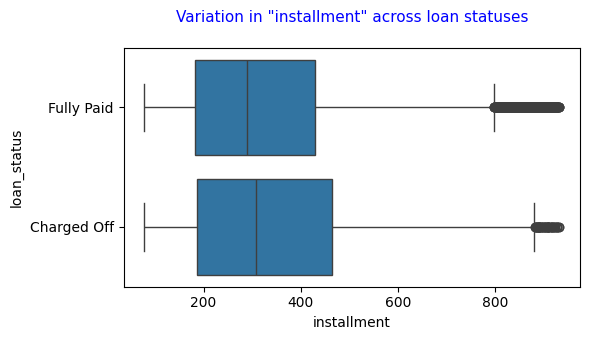

In [88]:
# Let's plot the installment across loan statuses
fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(6, 3.5)
sns.boxplot(data=loans_defaults_or_paid,x='installment',y='loan_status')
ax.set_title('Variation in "installment" across loan statuses\n', fontsize=11, color='blue', fontstyle='normal')
fig.tight_layout()
fig.show()


- **Interpretations**

  - The 75th percentile installment is higher in charged-off loan account. But there is no significant difference in the 25th percentile values across the loan statuses, indicating that loans with larger installments are more likely to default.

  - So we can use the `installment` as a factor to determine if a loan applicant may default as it seems to have a some influence on borrower loan statuses.

  - Installment variable showing similar behavior as the funded amount from investor, indicating <span style='color:blue'>high correlation</span> between them. We may require to perform hypothesis testing to ascertain whether the difference in the installment averages among loan statuses is statiscally significant.

5) `annual_inc`

In [89]:
loans_defaults_or_paid.groupby('loan_status', as_index=True)['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5064.000,59171.604,25311.545,24000.000,40000.000,54000.000,73000.000,140004.000
Fully Paid,29805.000,63718.944,26788.583,24000.000,42500.000,60000.000,80000.000,140004.000


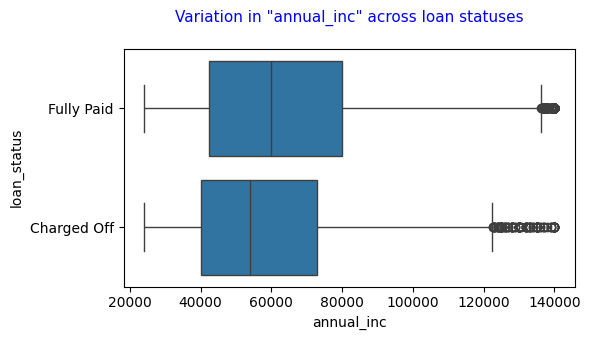

In [90]:
# Let's plot the annual_inc across loan statuses
fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(6, 3.5)
sns.boxplot(data=loans_defaults_or_paid,x='annual_inc',y='loan_status')
ax.set_title('Variation in "annual_inc" across loan statuses\n', fontsize=11, color='blue', fontstyle='normal')
fig.tight_layout()
fig.show()

- **Interpretations**


  - The annual income of loan defaulters at 75th percentile is lower than those who have fully paid back their loans. <br>But when we compare the 25th percentile incomes, they are different but not as significant as 75th percentile incomes. <br>This shows that the borrowers with higher income are less likely to default.

  - The determination of whether to approve or deny a loan application can be influenced by `annual_inc`.
  

6) `mths_since_last_delinq`

In [91]:
loans_defaults_or_paid.groupby('loan_status', as_index=True)['mths_since_last_delinq'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,1936.000,39.003,20.736,7.000,21.000,37.000,55.000,81.000
Fully Paid,10469.000,38.776,20.003,7.000,22.000,36.000,54.000,81.000


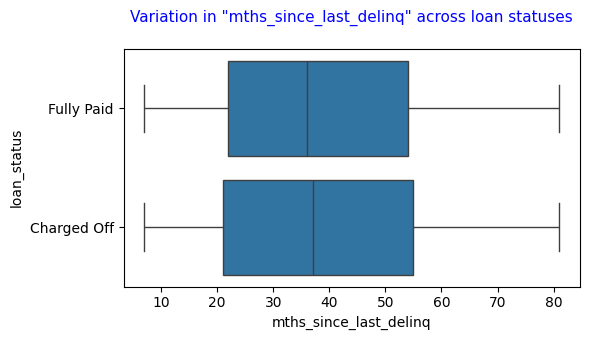

In [92]:
# Let's plot the mths_since_last_delinq across loan statuses
fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(6, 3.5)
sns.boxplot(data=loans_defaults_or_paid,x='mths_since_last_delinq',y='loan_status')
ax.set_title('Variation in "mths_since_last_delinq" across loan statuses\n', fontsize=11, color='blue', fontstyle='normal')
fig.tight_layout()
fig.show()

- **Interpretations**

  - The average of the mths_since_last_delinq variable for the loan defaulters is not significantly different than for the borrowers who have already paid in full. The quartiles (q1, q2, q3) do not vary significantly across the loan statuses, indicating the small difference in the averages is due to randomness. Hypothesis testing will be required to ascertain if the small difference in the averages is significant.

  - Thus it cannot be utlized as a driver variable behind loan defaults

7) `total_acc`

In [93]:
loans_defaults_or_paid.groupby('loan_status', as_index=True)['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5258.000,22.070,10.405,7.000,14.000,20.000,29.000,56.000
Fully Paid,31156.000,22.607,10.406,7.000,14.000,21.000,29.000,56.000


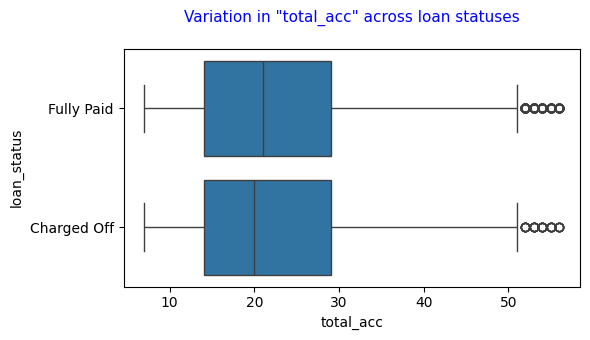

In [94]:
fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(6, 3.5)
sns.boxplot(data=loans_defaults_or_paid,x='total_acc',y='loan_status')
ax.set_title('Variation in "total_acc" across loan statuses\n', fontsize=11, color='blue', fontstyle='normal')
fig.tight_layout()
fig.show()

- **Interpretations**


  - Total credit lines may not be a reliable indicator of whether a loan applicant will default, as seen by the quartiles (q1, q2, q3) in total credit lines that do not differ considerably between borrowers who have defaulted and those who have fully repaid their debts. 
  
  - It also helps to understand that randomness may have caused the tiny difference in the average total credit lines across the loan statuses. To make sure that this tiny variation in averages is statistically significant and not due to randomness, hypothesis testing can be necessary.

<span style="color:green">**Top Influencer** among <u>numerical columns</u> that are more likely to influence loan_status</span>

In [95]:
mean_vals = loans_defaults_or_paid.groupby('loan_status', as_index=True)[
    ['int_rate', 'funded_amnt_inv', 'installment', 'annual_inc']
].agg('mean')
var_diff = ((mean_vals.max(axis=0) - mean_vals.min(axis=0))/mean_vals.min(axis=0)*100).round(2).sort_values(ascending=False).to_frame(name=f'%diff_mean')
var_diff.index.name = 'influencers'
var_diff['rank'] = np.arange(1, var_diff.size+1)
var_diff

,%diff_mean,rank
influencers,,
int_rate,17.740,1
annual_inc,7.690,2
funded_amnt_inv,6.020,3
installment,5.160,4


- `Interpretation`

  - <span style="color:blue">***int_rate*** being the top influencer among the numerical variables, can help to strongly decide if the loan applicant would default.</span>

#### **Segmented Univariate Analysis on Categorical Variables to assess their impact on Loan Statuses** <br> **(including few numerical columns used as ordered categorical variables)

- Split the number of <span style='color:blue'>open_acc</span> into bins. The bins will be stored in a separate variable as a <span style='color:green'>***Data Driven Metric***</span>

In [96]:
# Split the 'open_acc' into 7 bins
loans_defaults_or_paid['open_acc_groups'] = pd.cut(loans_defaults_or_paid['open_acc'],
                                                    bins=7,
                                                    precision =0,
                                                    labels=['2-8','8-14','14-20','20-26','26-32', '32-38', '38-44'])

- Create a function to visualize bar plots for segmented univariate analysis on categorical variables

In [97]:
def create_bar_plot_seg_univar(dframe, index_col, col, W, H, width, bbox_H, bbox_W, 
                               annotate_flag:bool=True, rotate_annotation:int=0, size:int=10):
    '''
    Create bar plots for segmented univariate analysis on categorical variables

    Params:
       dframe: A dataframe to read
       index_col: A variable name to access in the dataframe and used as an index to create a pivot table
       col: A variable name to access in the dataframe and used as a column to create a pivot table
       W: A number to set the width of the plot
       H: A number to set the height of the plot
       width: A number to set the width of the bars in the plot
       bbox_H: Height of the bbox to anchor
       bbox_W: Width of the bbox to anchor
       annotate_flag: Default to True, will add annotations to the plot
       rotate_annotation: Default to 0, will not rotate the annotations in the plot
       size: Default to 10, will set the size of annotations compared to the specified value
    '''
    if not isinstance(index_col, str) or not isinstance(col, str):
        raise TypeError(f'Both "index_col" and "col" must be of type str.')
    if not isinstance(W, int) or not isinstance(H, int):
        raise TypeError(f'fig heights (H) and widths (W) must be of type int.')
    if not isinstance(annotate_flag, bool):
        raise TypeError(f'"annotate_flag" must be of type bool.')
    if not isinstance(rotate_annotation, int):
        raise TypeError(f'"rotate_annotation" must be of type int.')
    if not isinstance(width, float):
        raise TypeError(f'"width" must be a float.')
    if not isinstance(bbox_W, float) or not isinstance(bbox_H, float):
        raise TypeError(f'anchor heights (bbox_H) and widths (bbox_W) must be of type float.')
    if isinstance(dframe, pd.DataFrame):
        try:
            x = dframe.pivot_table(index=index_col, columns=col, aggfunc='size')
            fig = plt.figure()
            fig.set_size_inches(w=W, h=H)
            ax = plt.subplot(111)
            z = np.arange(0, dframe[col].nunique())
            offset = 0
            rand_colors = np.random.choice(['yellow', 'pink', 'cyan'],
                                        x.index.nunique(),
                                        replace=False)
            for idx, legend_labels in enumerate(x.index):
                ax.bar(x=z+offset, height=x.loc[legend_labels], align='center', edgecolor='red', color=rand_colors[idx], width=width)
                if annotate_flag:
                    for xy in zip(z+offset, x.loc[legend_labels], z):
                        ax.annotate(xy=xy[:-1], text=f'{round(xy[1]/x.iloc[:, xy[2]].sum(axis=0)*100, 1)}%',
                                    horizontalalignment='left', verticalalignment='bottom', 
                                    rotation=rotate_annotation, size=size, fontweight=20)
                offset += width
            ax.set_xticks(ticks=z+width, labels=x.columns, rotation=90, fontsize=10, fontweight=20)
            ax.set_xlabel(col, fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='oblique'))
            ax.set_ylabel('count  of  '+index_col, fontdict=dict(fontsize=10, fontweight=20, color='green', fontstyle='oblique'))
            ax.legend(labels=x.index, fontsize=8, bbox_to_anchor=(bbox_W, bbox_H))
            if annotate_flag:
                fig.suptitle(f'Variability of "{col}" in relation to "{index_col}"', size=13, color='blue', fontstyle='oblique', y=1.05)
                ax.set_title(f'[ percentage = (no. of Charged-Off or Fully-Paid loans) divided by total loans in each category of "{col}" ]\n',
                         fontdict=dict(fontsize=10, fontweight=20, color='black', fontstyle='normal'),
                         loc='center')
            else:
                fig.suptitle(f'Variability of "{col}" in relation to "{index_col}"', size=13, color='blue', fontstyle='oblique', y=1)
            plt.show()
        except Exception as e:
            raise e        
    else:
        raise TypeError('Argument "dframe" must be a DataFrame')

> Find the influencers of `defaulted` loans among the categorical variables

1) <span style='color:green'>**term**</span>

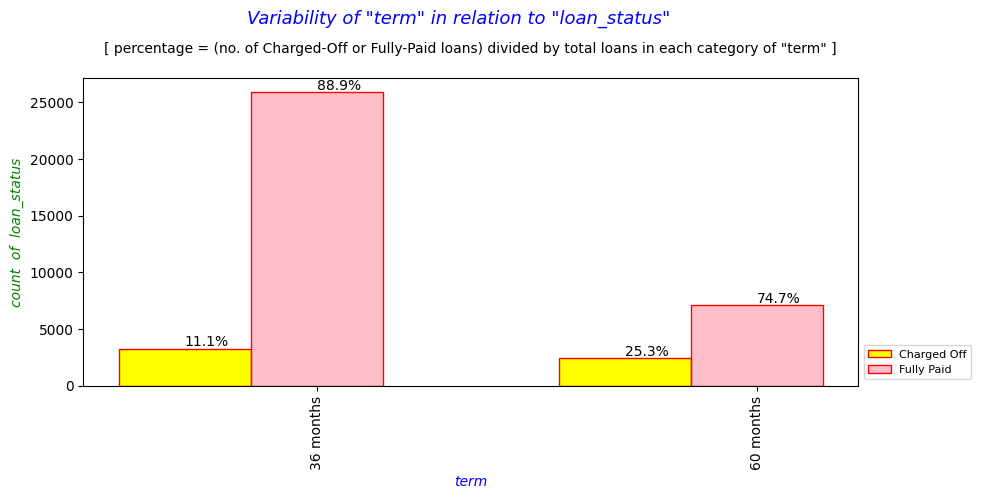

In [98]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='term', 
                           W=10, H=4, width=.3, bbox_W=1.0, bbox_H=.15, annotate_flag=True)

- `Interpretation`

   - There are significantly more fully paid loans with a 36-month tenure than there are loans with a 60-month tenure. It also shows that there is less risk of default if loans are repaid within the 36-month period because borrowers are more likely to repay their loans successfully within this shorter timeframe. The percentage of loans that default within a 36-month period is less than half of the percentage of loans that default during a 60-month period.

   - Thus, it is possible to identify applicants who may default using the **term** variable.

2) <span style='color:green'>**composite_grade**</span>

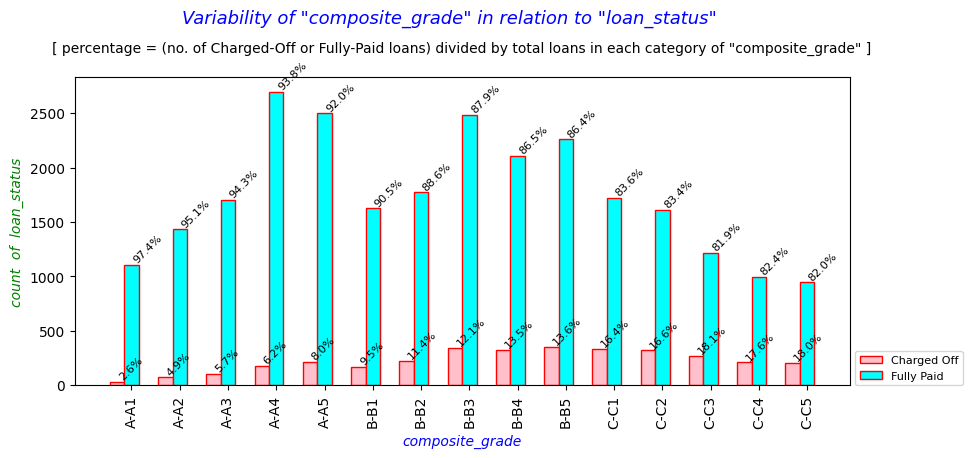

In [99]:
loans_with_composite_grades = loans_defaults_or_paid[loans_defaults_or_paid.composite_grade.isin(
    np.sort(loans_defaults_or_paid.composite_grade.unique())[:15]
    )]
create_bar_plot_seg_univar(loans_with_composite_grades, index_col='loan_status', col='composite_grade', 
    W=10, H=4, width=.3, bbox_W=1.0, bbox_H=.13, annotate_flag=True, rotate_annotation=45, size=8
)

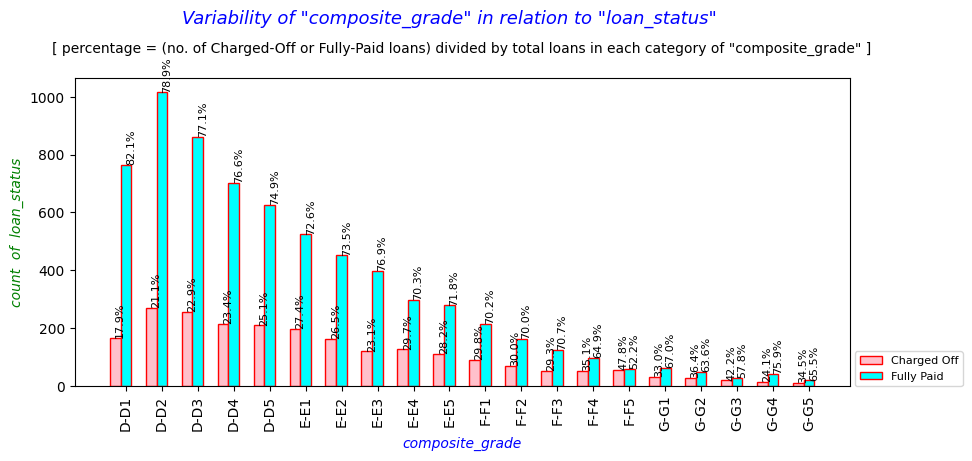

In [100]:
loans_with_composite_grades = loans_defaults_or_paid[loans_defaults_or_paid.composite_grade.isin(
    np.sort(loans_defaults_or_paid.composite_grade.unique())[15:]
)]

create_bar_plot_seg_univar(loans_with_composite_grades, index_col='loan_status', col='composite_grade', 
    W=10, H=4, width=.3, bbox_W=1.0, bbox_H=.13, annotate_flag=True, rotate_annotation=90, size=8
)

- `Interpretations`

  - We see a very less proportion of loan defaults among high sub-graded borrowers (such as <span style='color:green'>A-A1</span>, <span style='color:green'>A-A2</span>, <span style='color:green'>A-A3</span>) because they are more likely to repay their debts than low composite-graded borrowers. Thus, it appears from the data that borrowers with lower composite-grades have a lower likelihood of repaying their debts.

  - The applicants with lower **composite_grade** may have a higher chance of defaulting, so we may decline their loan requests.  

3) <span style='color:green'>**purpose**</span>

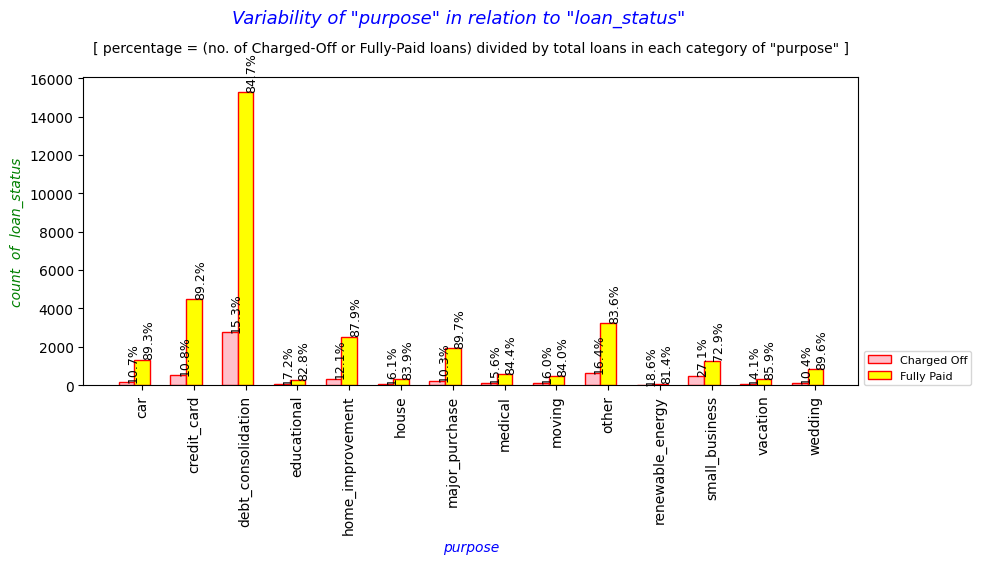

In [101]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='purpose',
                           W=10, H=4, width=.3, bbox_W=1.0, bbox_H=.13, annotate_flag=True, rotate_annotation=90, size=9)

- `Iterpretation`

  - The percentage of defaulters is higher when their pupose of taking loans is either <span style='color:green'>Debt Consolidation</span>, <span style='color:green'>Educational</span>, <span style='color:green'>House</span>, <span style='color:green'>Medical</span>,
  <span style='color:green'>Moving</span>, <span style='color:green'>Other</span>, <span style='color:green'>Renewable Energy</span>, <span style='color:green'>Vacation</span>. <br>The majority of defaults occur when borrowers take <span style='color:red'>Small Business</span> loans, which makes up about <span style='color:green'>27%</span> of all borrowers who take out these kinds of loans.

  - There is a significant difference in the percentage of defaulters depending on the loan purposes, indicating that this variable is a strong indicator of determining whether the applicant would default. 

4) <span style='color:green'>**open_acc_groups**</span>

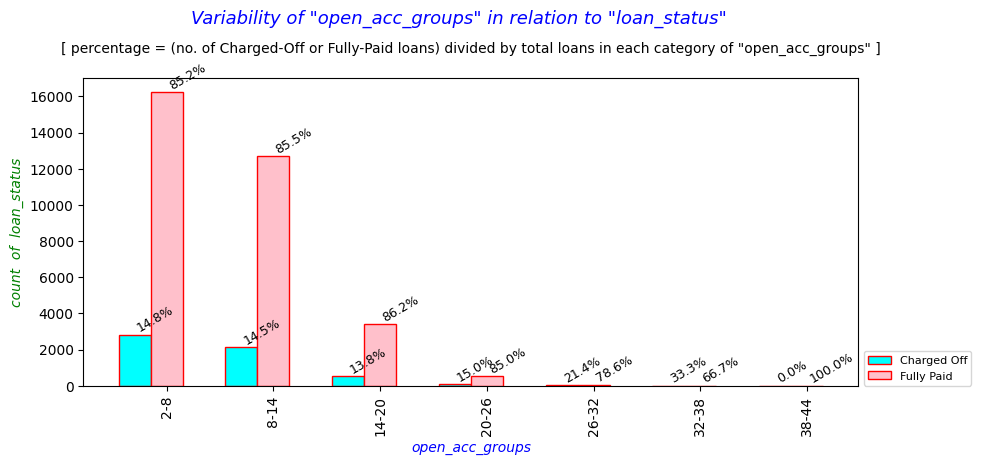

In [102]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='open_acc_groups',
                           W=10, H=4, width=.3, bbox_W=1.0, bbox_H=.13, annotate_flag=True, rotate_annotation=30, size=9)

- `Interpretations`


  - Loan requests from applicants with fewer open credit lines have a higher chance of being approved by the lender. 
  
  - There appears to be little difference in the percentage of defaulters having less than 26 open credit lines across credit line groups. However, if the borrowers have more than 26 credit lines in the past which are still opened, they are more likely to default. It demonstrates that in the case of loan applicants who might default, **open_acc** may have an affect on the outcome.

5) <span style='color:green'>**verification_status**</span>

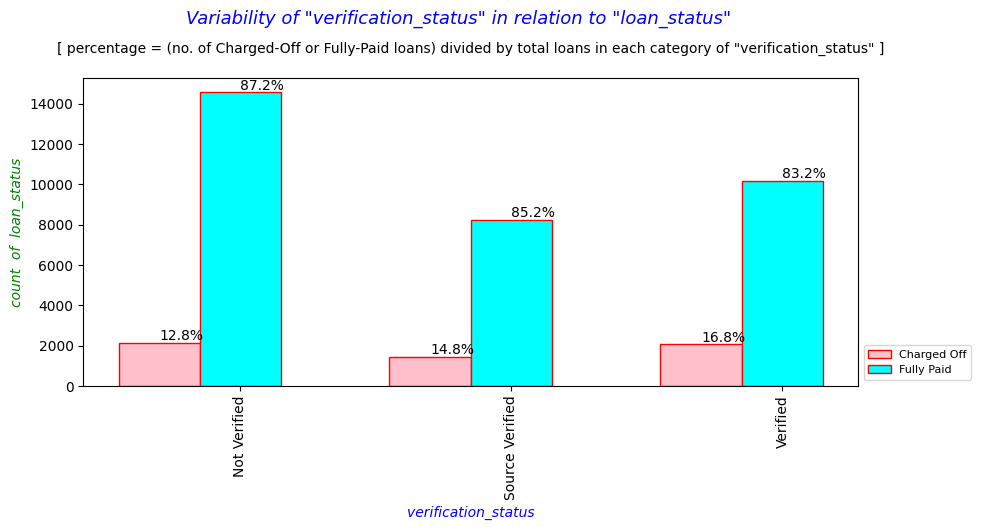

In [103]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='verification_status', 
                           W=10, H=4, width=.3, bbox_W=1.0, bbox_H=.15)

- `Interpretations`

  - Although the unverified borrowers had a greater chance of repaying their debt in full, the proportion of borrowers who default does not seem to differ significantly between the verification statuses. It may be due to randomness.

  - Hence, the borrowers' verification statuses have a lesser influence on their risk of defaulting, suggesting that this variable may not be used to detect applicants who can default. However, to make sure that this tiny variation in the percentage of borrowers who default or pay their debt in full is not due to randomness, we may perform hypothesis testing.

6) <span style='color:green'>**emp_length**</span>

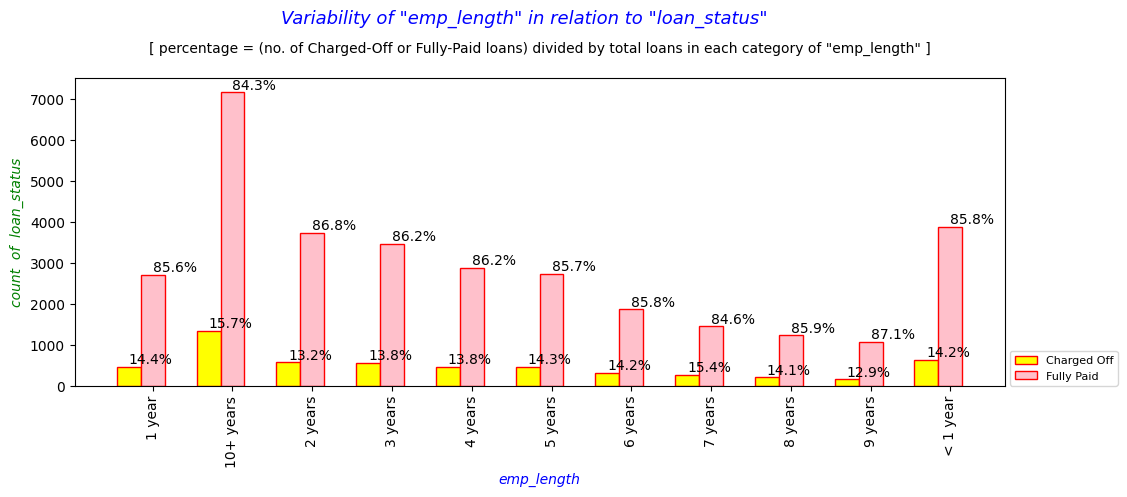

In [104]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='emp_length',
                           W=12, H=4, width=.3, bbox_W=1.0, bbox_H=.13)

- `Interpretations`

  - The lender approves a significant number of loan requests from applicants who have more than ten years of job experience. <br> There is less of a significant difference in the percentage of borrowers who have fully paid their loans or defaulted across different years of experience, may be due to randomness. The data does not suggest that borrowers with less than ten years of experience are more likely to default on their loans.

  - Therefore, it is unlikely that ***emp_length*** will have an impact on reducing the risk of default. <br>However, we can conduct hypothesis testing to make sure that this tiny variation in the percentage of borrowers who default or pay their debt in full, between their employment lengths, is significant and is not due to randomness.

7) <span style='color:green'>**addr_state**</span>

In [105]:
loans_defaults_or_paid.addr_state.unique()[:15]

array(['AZ', 'GA', 'IL', 'CA', 'NC', 'TX', 'VA', 'MO', 'CT', 'UT', 'FL',
       'NY', 'PA', 'MN', 'NJ'], dtype=object)

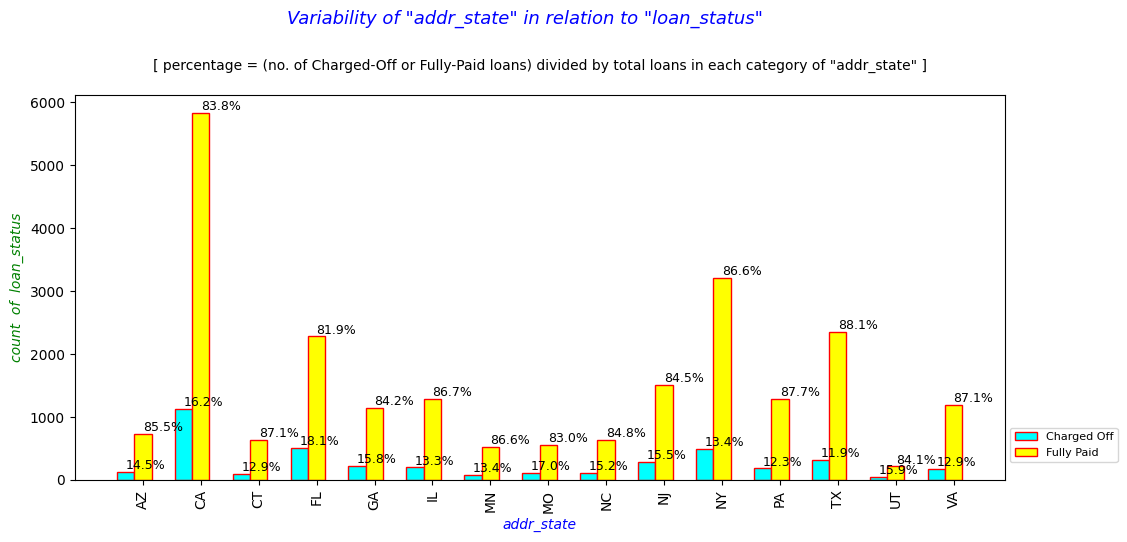

In [106]:
create_bar_plot_seg_univar(loans_defaults_or_paid[loans_defaults_or_paid.addr_state.isin(loans_defaults_or_paid.addr_state.unique()[:15])], 
                           index_col='loan_status', col='addr_state', 
                           W=12, H=5, width=.3, bbox_W=1.0, bbox_H=.15, annotate_flag=True, rotate_annotation=0, size=9)

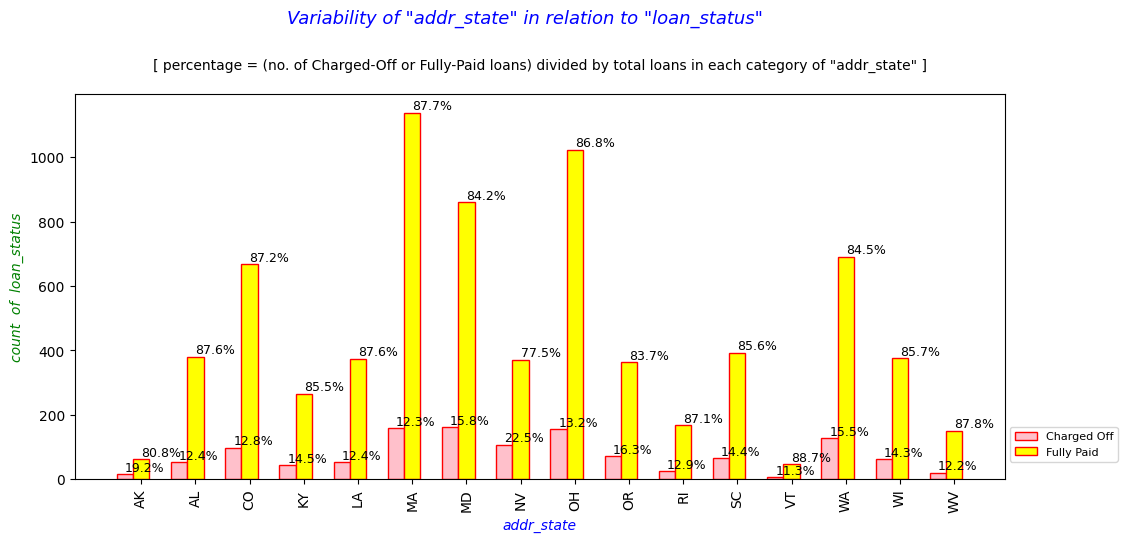

In [107]:
create_bar_plot_seg_univar(loans_defaults_or_paid[loans_defaults_or_paid.addr_state.isin(loans_defaults_or_paid.addr_state.unique()[15:31])], 
                           index_col='loan_status', col='addr_state', 
                           W=12, H=5, width=.3, bbox_W=1.0, bbox_H=.15, annotate_flag=True, rotate_annotation=0, size=9)

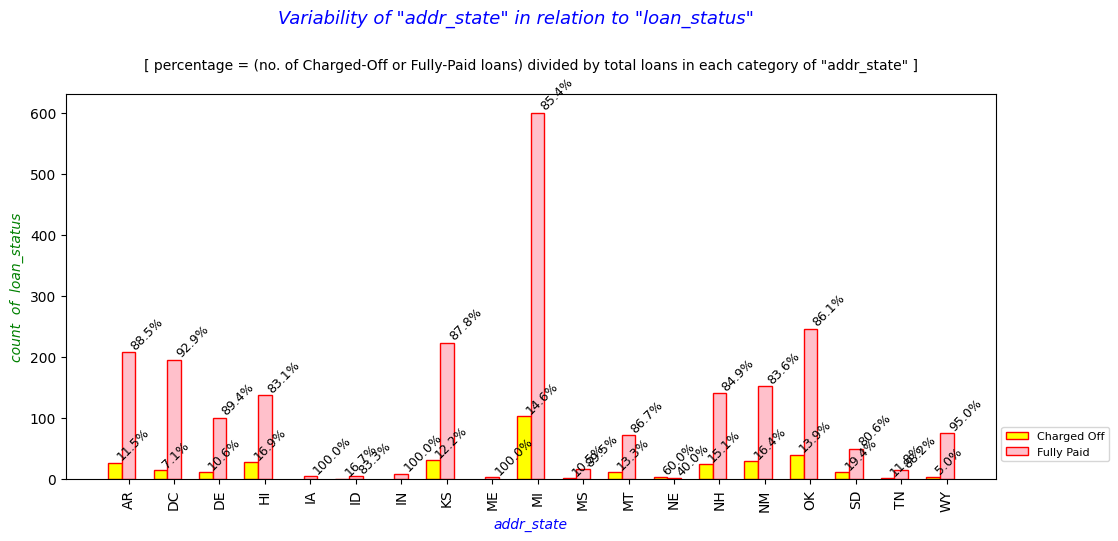

In [108]:
create_bar_plot_seg_univar(loans_defaults_or_paid[loans_defaults_or_paid.addr_state.isin(loans_defaults_or_paid.addr_state.unique()[31:])], 
                           index_col='loan_status', col='addr_state', 
                           W=12, H=5, width=.3, bbox_W=1.0, bbox_H=.15, annotate_flag=True, rotate_annotation=45, size=9)

- `Interpretations`
  
  
  - The observation suggests that there is a significant difference in the percentage of defaults among borrowers from different states. So, it is likely to detect loan applications who may default using this variable. 

  - From the state <span style='color:red'>ME</span>, all borrowers were in default. 60% of debtors in <span style='color:green'>NE</span> have defaulted. Of the borrowers in <span style='color:green'>NV</span>, 23% have defaulted.  The percentage of defaulters varies primarily between 10% and 20% among the US states.

8) <span style='color:green'>**home_ownership**</span>

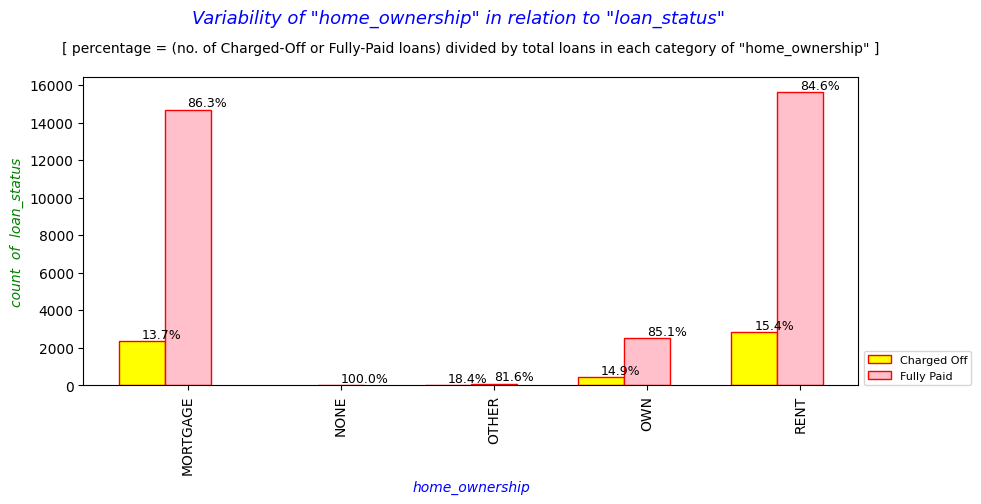

In [109]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='home_ownership', 
                           W=10, H=4, width=.3, bbox_W=1.0, bbox_H=.13, size=9)

- `Interpretations`

  - Lender granted more number credits to borrowers with rental or mortgaged homes than to those with owned properties. In contrast to debtors who still own their homes or have rented properties, individuals who have mortgaged properties are more likely to repay their debts. But the percentage of loan defaults does not vary significantly between home ownership statuses of the borrowers, which suggests that the probability of a default may not depend on the borrower's home ownership status.
  
  - Thus, it may not be possible to identify applicants who may default using this variable. We may require to perform hypothesis testing to ascertain whether the difference in the proportion of defaulters between home ownership statuses is significant.

9) <span style='color:green'>**issue_month**</span>

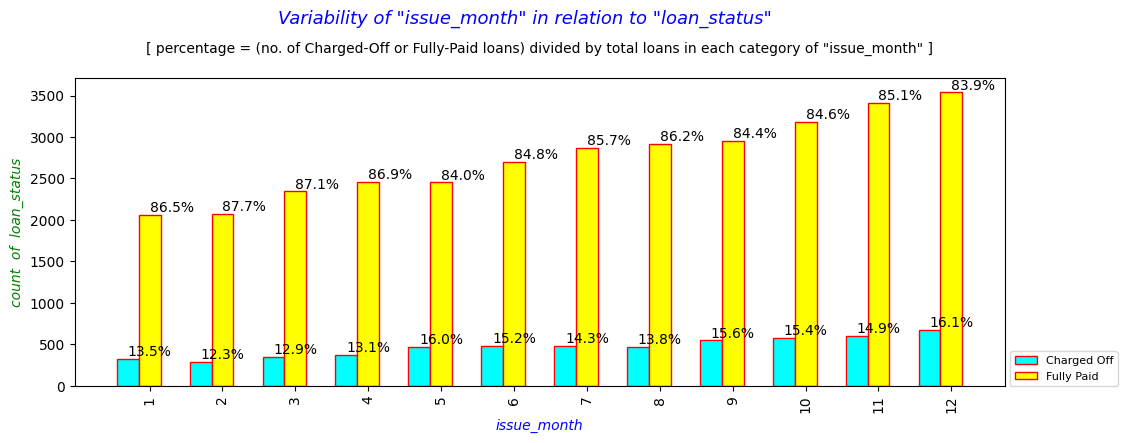

In [110]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='issue_month', 
                           W=12, H=4, width=.3, bbox_W=1.0, bbox_H=.13)

- `Interpretation`

  - The percentage of loan defaults does not significantly differ between the months in which the loans were issued. Thus, it does not suggest to use this variable to determine if the loan applicant would default. These tiny differences in the percentages of defaults throughout the course of the months could have been caused by randomness. In order to confirm that this tiny difference is statistically significant, we might need to perform hypothesis testing.

10) <span style='color:green'>**issue_year**</span>

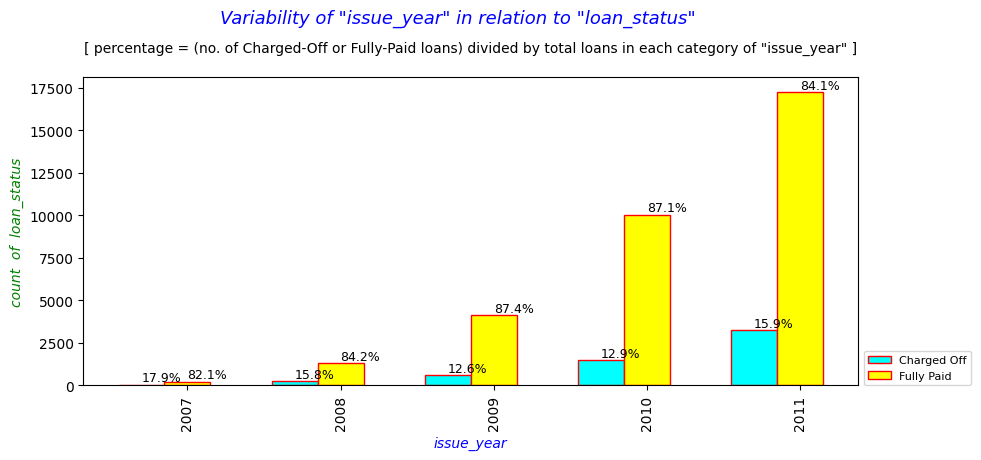

In [111]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='issue_year', 
                           W=10, H=4, width=.3, bbox_W=1.0, bbox_H=.13, size=9)

- `Interpretation`

  - The percentage of defaulters does not significantly differ between the recent years (2008-2011) when the loans were granted.

  - It might not be accurate to assess default risk for new loan applicants by using the year of the loan issue date. The year that a loan was first issued is known as the loan issue year, and it has nothing to do with the borrower's capability to repay.

11) <span style='color:green'>**earliest_cr_line_month**</span>

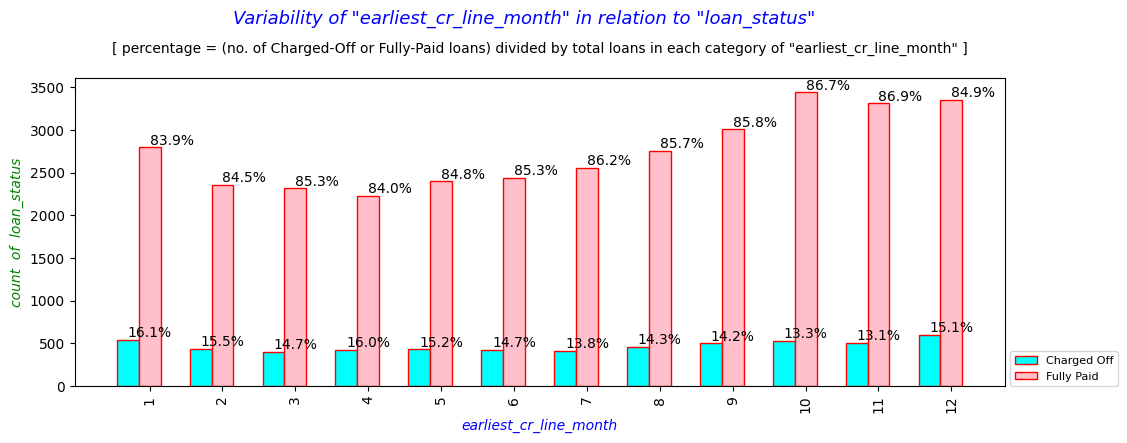

In [112]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='earliest_cr_line_month',
                           W=12, H=4, width=.3, bbox_W=1.0, bbox_H=.13)

- `Interpretations`

  - The percentage of defaulters do not vary significantly in relation to the months when they reported their earliest credit lines. Hence the variable is insignificant to determine if the loan applicant would default. Hypothesis testing is suggested to ascertain that the small differences in the percentage of defaulters compared to their earliest credit line month is not due to randomness.

12) <span style='color:green'>**earliest_cr_line_year**</span>

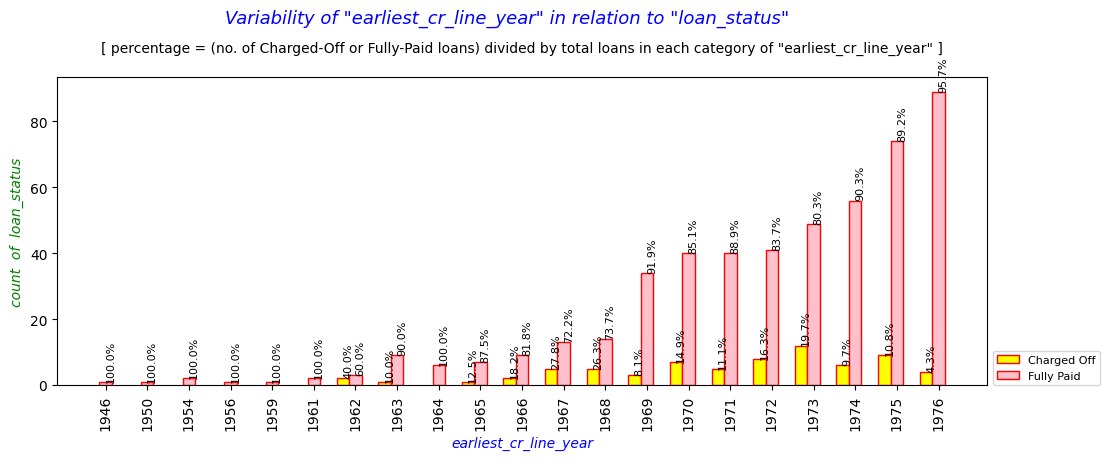

In [113]:
create_bar_plot_seg_univar(loans_defaults_or_paid[loans_defaults_or_paid.earliest_cr_line_year<1977], 
                           index_col='loan_status', col='earliest_cr_line_year', 
                           W=12, H=4, width=.3, bbox_W=1.0, bbox_H=.13, annotate_flag=True, rotate_annotation=90, size=8)

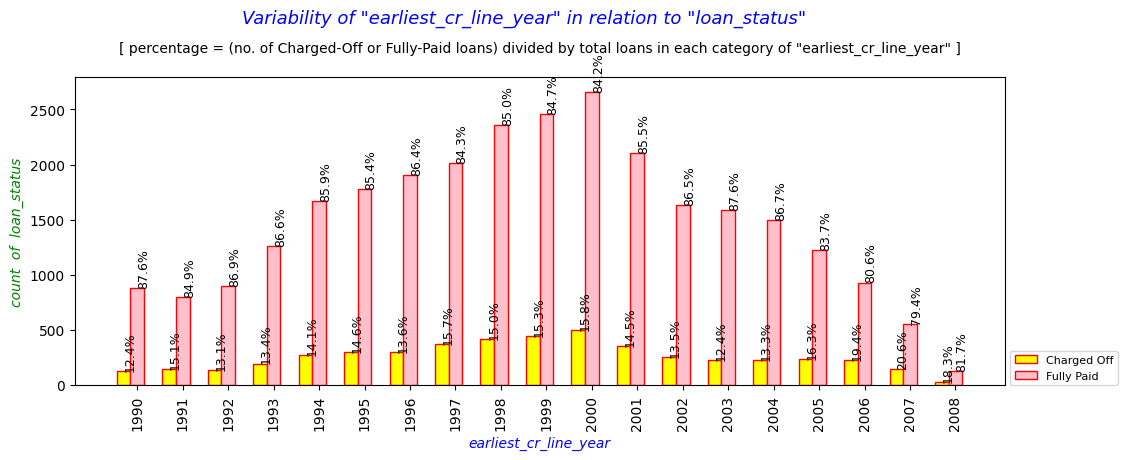

In [114]:
create_bar_plot_seg_univar(loans_defaults_or_paid[loans_defaults_or_paid.earliest_cr_line_year>1989], 
                           index_col='loan_status', col='earliest_cr_line_year', 
                           W=12, H=4, width=.3, bbox_W=1.0, bbox_H=.13, annotate_flag=True, rotate_annotation=90, size=9)

- `Interpretation`

  - Borrowers who have earliest credit line dates in the years **1966, 1967, 1968, 1946, 1950, 1956** have defaulted the most.
  
  - When compared to the recent years in which borrowers reported their earliest credit lines, the percentage of defaulters does not vary significantly. As a result, the variable has little impact on whether the loan application defaults. 
  
  - However, we can conduct hypothesis testing to make sure that this tiny variation in the percentage of borrowers who default or pay their debt in full, between their earliest credit line years, is significant and is not due to randomness.

13) <span style='color:green'>**delinq_2yrs**</span>

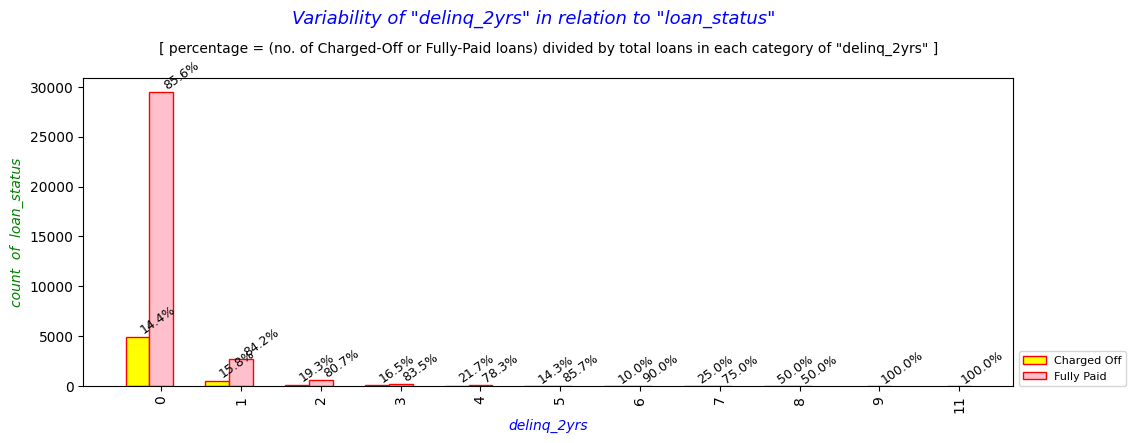

In [115]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='delinq_2yrs',
                           W=12, H=4, width=.3, bbox_W=1.0, bbox_H=.13, annotate_flag=True, rotate_annotation=35, size=9)

- `Interpretation`


   - Borrowers who have not missed their loan repayments in the last two years are more likely to make loan repayments than those who have missed payments at least once in the previous two years and are therefore more likely to default. Thus, borrowers' loan default rates will increase in proportion to their delinquency.

   - Hence, **delinq_2yrs** can help to identify applicants who may default on their loans

14) <span style='color:green'>**inq_last_6mths**</span>

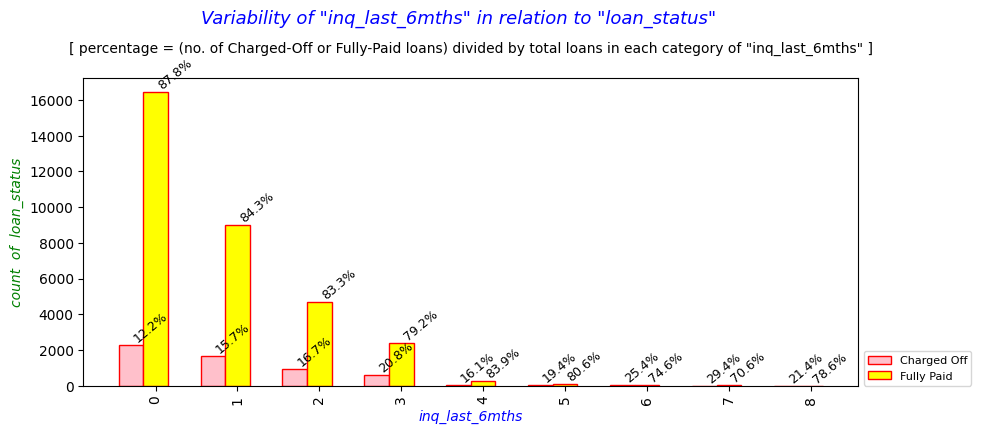

In [116]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='inq_last_6mths', 
                           W=10, H=4, width=.3, bbox_W=1.0, bbox_H=.13, rotate_annotation=40, size=9)

- `Interpretation`


  - The likelihood of defaulting appears to be lower for borrowers who have not inquired about loans in the last six months than for those who did.

  -  Thus, it is possible to identify loan applicants who may default using this variable.

15) <span style='color:green'>**pub_rec**</span>

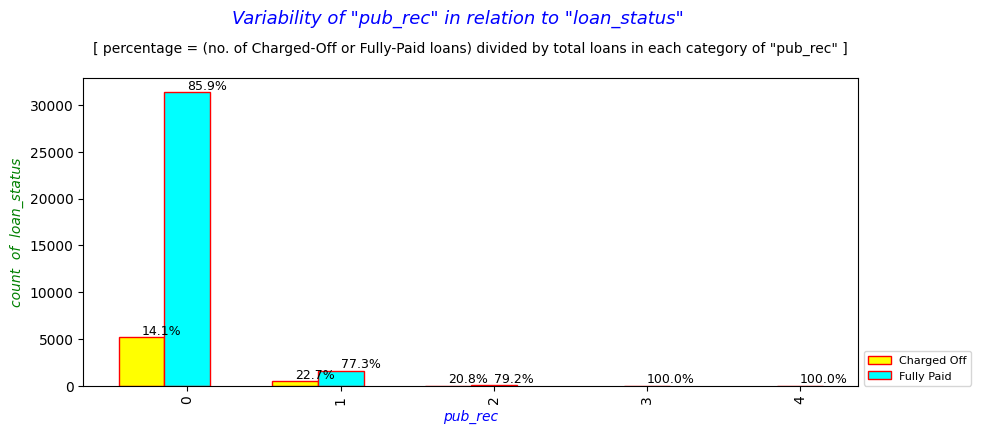

In [117]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='pub_rec', 
                           W=10, H=4, width=.3, bbox_W=1.0, bbox_H=.13, size=9)

- `Interpretation`

  - There is a greater percentage of defaults among borrowers who have at least one derogatory past than among those who have none, suggesting that borrowers with less recorded derogatories are probably going to repay their loans. 

  - Hence, **pub_rec** is a strong driver to identify loan applicants who may default

16) <span style='color:green'>**pub_rec_bankruptcies**</span>

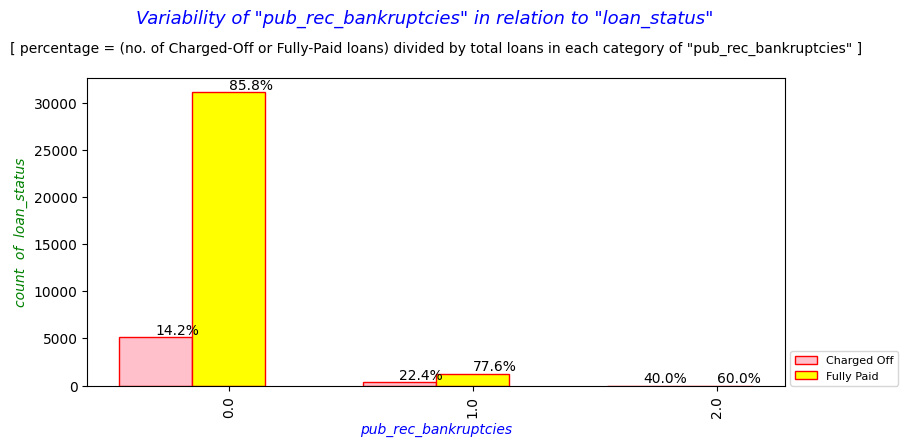

In [118]:
create_bar_plot_seg_univar(loans_defaults_or_paid, index_col='loan_status', col='pub_rec_bankruptcies',
                           W=9, H=4, width=.3, bbox_W=1.17, bbox_H=.13)

- `Interpretation`

  - We observe a lower percentage of loan defaults among borrowers who have never reported their bankruptcies, compared to borrowers who have reported bankruptcy atleast once. Thus, the data suggest that borrowers have lesser likelihood of repaying their loans who have reported bankruptcies once or twice earlier.

  - So, it is highly likely that ***pub_rec_bankruptcies*** will have an impact on whether the loan application can be approved or denied. 

<span style="color:blue">**Top Influencers** among <u>categorical columns</u> that are more likely to influence loan_status</span><br>
** (including few numerical coulmns used as ordered categorical variables)

   - term
   - composite_grade
   - purpose
   - addr_state
   - delinq_2yrs
   - inq_last_6mths
   - pub_rec
   - pub_rec_bankruptcies
   - open_acc **or** open_acc_groups (**moderate impact**)

#### **Bivariate Analysis on Numerical Variables**

- Basis the **segmented analysis**, choosing the factors that are **more likely** to identify default risk among loan applicants and calculating their correlation scores

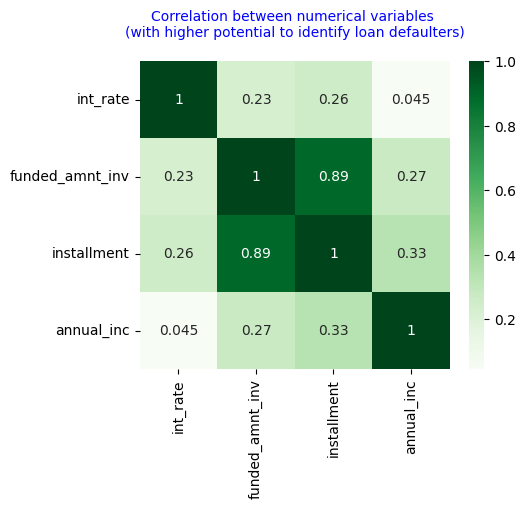

In [119]:
fig = plt.figure()
fig.set_size_inches(5, 4)
correlation_matrix = loans_defaults_or_paid[['int_rate', 'funded_amnt_inv', 'installment', 'annual_inc']].corr()
ax = sns.heatmap(correlation_matrix, annot = True, cmap='Greens')
plt.title("Correlation between numerical variables \n(with higher potential to identify loan defaulters)\n",
          fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='normal'))
plt.show()

- `Interpretation`

  - **installment** and **funded_amnt_inv** are highly correlated variables. <br><br>
  <span style="color:blue">So, we can derive a ***Data Driven Metric*** as the ratio of the loan <span style="color:green">installment</span> to the amount that is funded by the investor (<span style="color:green">funded_amnt_inv</span>) for each borrower to take out the correlation effect which will prevent the model from overfitting</span>.


In [120]:
# calculating ratio and storing it wit the dataframe
loans_defaults_or_paid['ratio_installment_to_funded_amnt_inv'] = loans_defaults_or_paid['installment']/loans_defaults_or_paid['funded_amnt_inv']

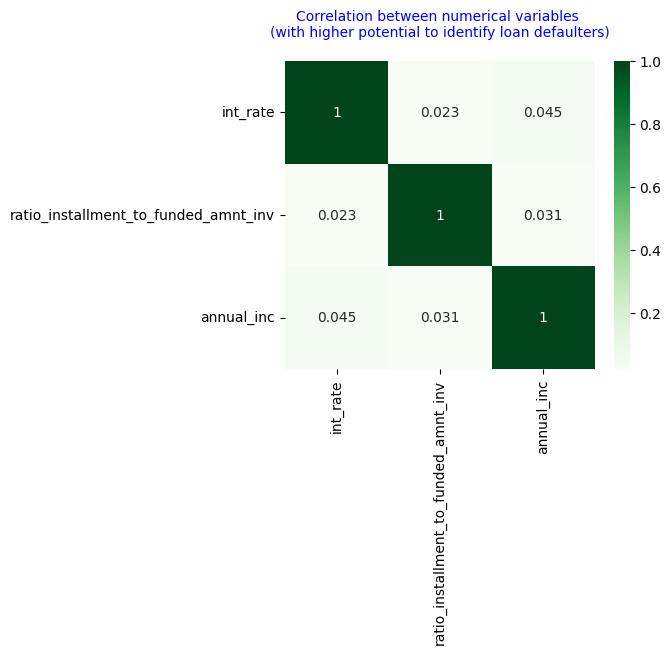

In [121]:
fig = plt.figure()
fig.set_size_inches(5, 4)
correlation_matrix = loans_defaults_or_paid[['int_rate', 'ratio_installment_to_funded_amnt_inv', 'annual_inc']].corr()
ax = sns.heatmap(correlation_matrix, annot = True, cmap='Greens')
plt.title("Correlation between numerical variables \n(with higher potential to identify loan defaulters)\n",
          fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='normal'))
plt.show()

- `Interpretaion`

  - The <span style="color:green">ratio_installment_to_funded_amnt_inv</span> variable is weakly correlated to other numerical variables, making it an independent feature which will prevent the model from overfitting.

#### **Bivariate Analysis on Categorical Variables**<br> ** (including few numerical coulmns used as ordered categorical variables)

1) <span style='color:green'>open_acc_groups</span> vs <span style='color:green'>term</span>

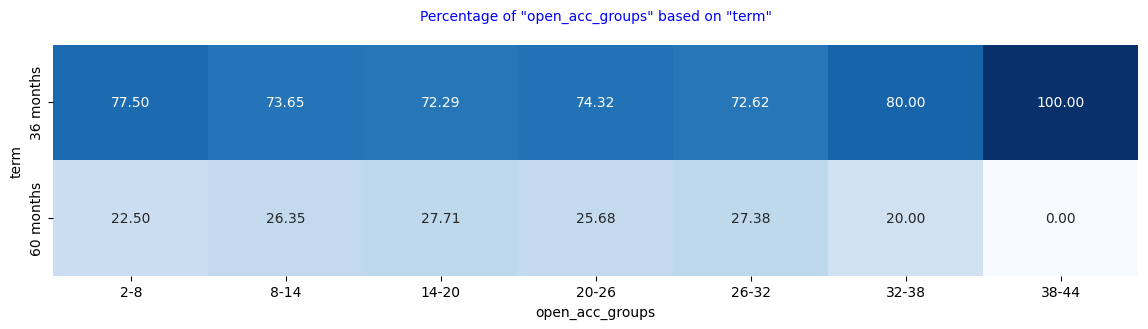

In [122]:
fig = plt.figure()
fig.set_size_inches(w=14, h=3)
pivot_term_purpose = loans_defaults_or_paid.pivot_table(index='term', columns='open_acc_groups', aggfunc='size')
sns.heatmap(pivot_term_purpose.apply(lambda x:round(x/x.sum()*100, 2), axis=0), annot=True, cmap='Blues', fmt=".2f", cbar=False)
plt.title('Percentage of "open_acc_groups" based on "term"\n', 
          fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='normal'))
plt.show()

- `Illustration`

  - <span style='color:blue'>open_acc_groups</span> and <span style='color:blue'>term</span> are **less** corrleated

  - Because the percentage of borrowers with 36-month/60-month loan terms do not vary significantly in relation to their open credit line groups except when they have more than 38 open credit lines, indicating that these factors may have less correlation between them. We may require to do hypothesis testing to determine whether the small difference in the proportion is not due to randomness and is statistically significant

2) <span style='color:green'>purpose</span> vs <span style='color:green'>term</span>

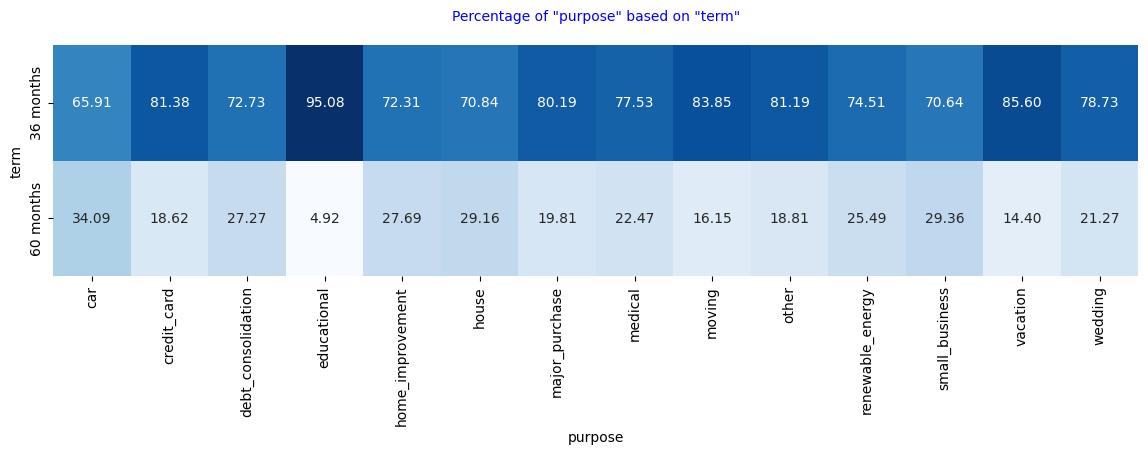

In [123]:
fig = plt.figure()
fig.set_size_inches(w=14, h=3)
pivot_term_purpose = loans_defaults_or_paid.pivot_table(index='term', columns='purpose', aggfunc='size')
sns.heatmap(pivot_term_purpose.apply(lambda x:round(x/x.sum()*100, 2), axis=0), annot=True, cmap='Blues', fmt=".2f", cbar=False)
plt.title('Percentage of "purpose" based on "term"\n', 
          fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='normal'))
plt.show()


- `Illustration`

  - <span style='color:blue'>purpose</span> and <span style='color:blue'>term</span> have **moderate** corrleation

  - Because the percentage of borrowers with either loan terms differs in relation to the loan purposes specifically against 36-month loan terms, but less significantly across most of the loan purposes, indicating that these factors have a moderate correlation between them. We can run hypotheisis testting to ascertain that the difference in proportion is highly signifcant

3) <span style='color:green'>delinq_2yrs</span> vs <span style='color:green'>term</span>

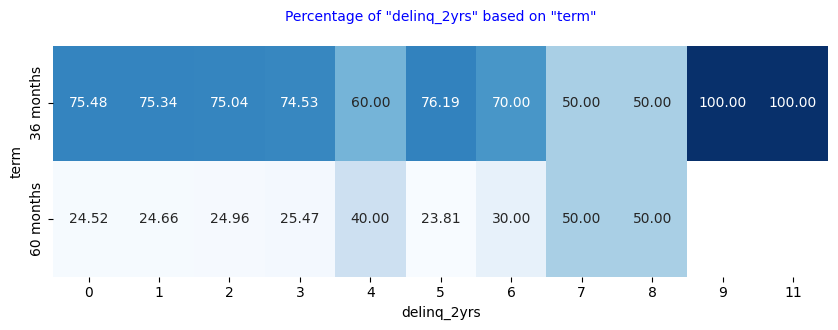

In [124]:
fig = plt.figure()
fig.set_size_inches(w=10, h=3)
pivot_term_purpose = loans_defaults_or_paid.pivot_table(index='term', columns='delinq_2yrs', aggfunc='size')
sns.heatmap(pivot_term_purpose.apply(lambda x:round(x/x.sum()*100, 2), axis=0), annot=True, cmap='Blues', fmt=".2f", cbar=False)
plt.title('Percentage of "delinq_2yrs" based on "term"\n', 
          fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='normal'))
plt.show()

- `Illustration`

  - <span style='color:blue'>delinq_2yrs</span> and <span style='color:blue'>term</span> have **moderate** correlation

  - Percentage of Borrowers with either of the loan terms differ significantly when they miss their loan repayments atleast 4 times in the last two years. But less than 4 times of their delinquency, the percentage of borrowers tend to vary less significantly. Hence, these factors are moderately correlated

4) <span style='color:green'>composite_grade</span> vs <span style='color:green'>term</span>

In [125]:
pivot_term_purpose = loans_defaults_or_paid.pivot_table(index='term', columns='composite_grade', aggfunc='size')
# Percentage of "composite_grade" based on "term"
pivot_term_purpose.apply(lambda x:round(x/x.sum()*100, 2), axis=0)

composite_grade,A-A1,A-A2,A-A3,A-A4,A-A5,B-B1,B-B2,B-B3,B-B4,B-B5,...,F-F1,F-F2,F-F3,F-F4,F-F5,G-G1,G-G2,G-G3,G-G4,G-G5
term,,,,,,,,,,,,,,,,,,,,,
36 months,100.000,99.070,97.730,95.820,91.900,90.090,86.160,77.700,74.640,75.490,...,20.330,23.180,17.820,25.170,23.010,21.280,16.880,8.890,16.670,34.480
60 months,NaN,0.930,2.270,4.180,8.100,9.910,13.840,22.300,25.360,24.510,...,79.670,76.820,82.180,74.830,76.990,78.720,83.120,91.110,83.330,65.520


- `Illustration`

  - <span style='color:blue'>composite_grade</span> and <span style='color:blue'>term</span> have a **high** correlation

  - Because the percentage of borrowers with 36-month/60-month loan terms differs significantly between their composite grades, indicating that these factors have a high correlation.

5) <span style='color:green'>pub_rec</span> vs <span style='color:green'>composite_grade</span>

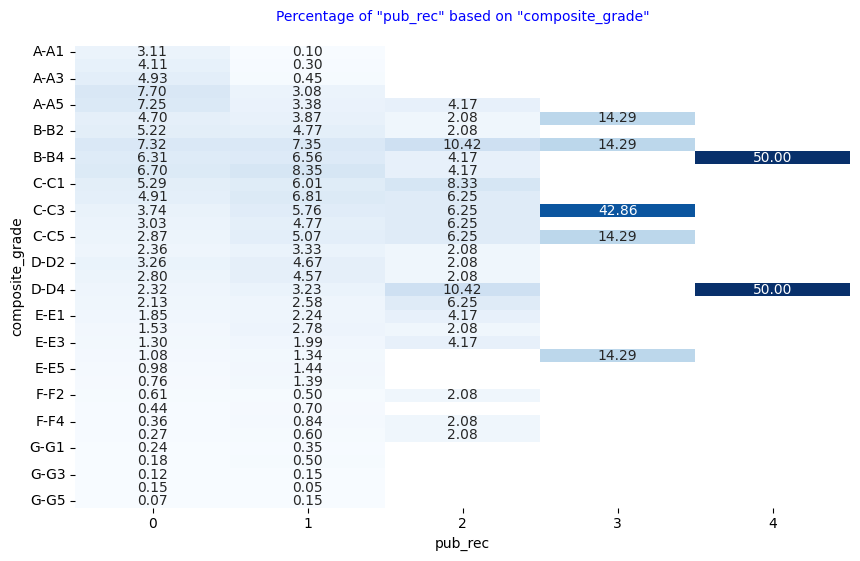

In [126]:
fig = plt.figure()
fig.set_size_inches(w=10, h=6)
pivot_term_purpose = loans_defaults_or_paid.pivot_table(index='composite_grade', columns='pub_rec', aggfunc='size')
sns.heatmap(pivot_term_purpose.apply(lambda x:round(x/x.sum()*100, 2), axis=0), annot=True, cmap='Blues', fmt=".2f", cbar=False)
plt.title('Percentage of "pub_rec" based on "composite_grade"\n', 
          fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='normal'))
plt.show()

- `Illustration`

  - <span style='color:blue'>composite_grade</span> and <span style='color:blue'>pub_rec</span> are **less** corrleated

  - Because the percentage of borrowers with varied composite grades does not differ significantly very often with increase in their negative history, indicating that these factors may have less correlation between them. We may push for hypothesis testing to ascertain the small difference in the proportions is not due to randomness

6) <span style='color:green'>inq_last_6mths</span> vs <span style='color:green'>composite_grade</span>

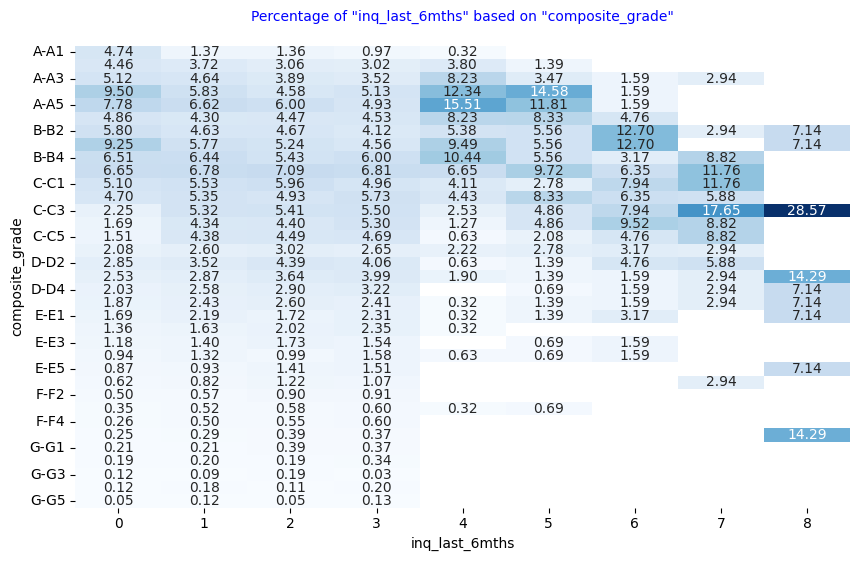

In [127]:
fig = plt.figure()
fig.set_size_inches(w=10, h=6)
pivot_term_purpose = loans_defaults_or_paid.pivot_table(index='composite_grade', columns='inq_last_6mths', aggfunc='size')
sns.heatmap(pivot_term_purpose.apply(lambda x:round(x/x.sum()*100, 2), axis=0), annot=True, cmap='Blues', fmt=".2f", cbar=False)
plt.title('Percentage of "inq_last_6mths" based on "composite_grade"\n', 
          fontdict=dict(fontsize=10, fontweight=20, color='blue', fontstyle='normal'))
plt.show()

- `Illustration`

  - <span style='color:blue'>inq_last_6mths</span> and <span style='color:blue'>composite_grade</span> are **highly** corrleated

  - It appears that there is a correlation between these variables because the percentage of borrowers who are at the higher composite grades than **D-D2** differ significantly among the number of the inquires they make in past 6 months. 

7) <span style='color:green'>pub_rec</span> vs <span style='color:green'>pub_rec_bankruptcies</span>

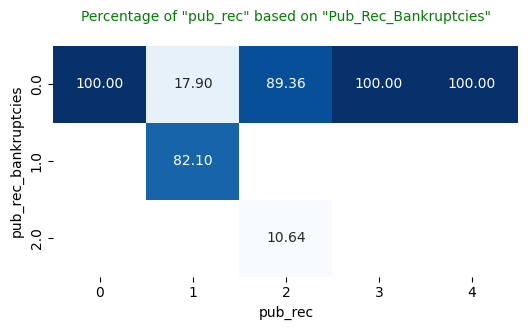

In [128]:
fig = plt.figure()
fig.set_size_inches(w=6, h=3)
pivot_term_purpose = loans_defaults_or_paid.pivot_table(index='pub_rec_bankruptcies', columns='pub_rec', aggfunc='size')
sns.heatmap(pivot_term_purpose.apply(lambda x:round(x/x.sum()*100, 2), axis=0), annot=True, cmap='Blues', fmt=".2f", cbar=False)
plt.title('Percentage of "pub_rec" based on "Pub_Rec_Bankruptcies"\n', 
          fontdict=dict(fontsize=10, fontweight=20, color='green', fontstyle='normal'))
plt.show()

- `Illustration`

  - <span style='color:blue'>pub_rec_bankruptcies</span> and <span style='color:blue'>pub_rec</span> are **less** corrleated

  - The fact that percentage of borrowers who have never filed for bankruptcy appear to have some public derogatory history, which does not significantly differ in terms of the number of such histories that is documented, suggests that there is little association between these features.

8) <span style='color:green'>addr_state</span> vs <span style='color:green'>delinq_2yrs</span>

In [129]:
pivot_term_purpose = loans_defaults_or_paid.pivot_table(index='delinq_2yrs', columns='addr_state', aggfunc='size')
# Percentage of "addr_state" based on "delinq_2yrs"
pivot_term_purpose.apply(lambda x:round(x/x.sum()*100, 2), axis=0).iloc[:3, :20]

addr_state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA
delinq_2yrs,,,,,,,,,,,,,,,,,,,,
0,85.900,84.600,89.790,87.510,89.510,90.860,88.290,92.890,84.070,89.930,88.370,87.350,100.000,83.330,89.650,88.890,90.590,91.000,90.160,87.510
1,8.970,12.180,7.660,10.130,8.250,7.050,8.820,5.210,13.270,7.910,9.420,9.040,NaN,NaN,7.580,11.110,8.630,7.400,7.030,10.020
2,5.130,2.070,2.550,1.770,1.550,1.170,1.790,1.900,1.770,1.620,1.400,1.810,NaN,16.670,1.960,NaN,NaN,0.320,1.640,1.700


- `Illustration`

  - <span style='color:blue'>addr_state</span> and <span style='color:blue'>delinq_2yrs</span> are **less** corrleated

  - It seems likely that these features are weakly correlated because the percentage of borrowers who have never missed a loan repayment or who have missed at least once in past 2 years do not differ significantly from one another when compared to their states.

<span style="color:green">**Top Influencers** among <u>categorical columns</u> that have impact on loan status and are more likely to influence each other</span>
   
   
   - <span style="color:blue">composite_grade</span> has a high correlation with <span style="color:blue">term</span> and <span style="color:blue">last_inq_6mths</span> variables. So, term may have a high correlation with last_inq_6mths variable


   - term is found to have moderate correlation with <span style="color:blue">purpose</span> and <span style="color:blue">delinq_2yrs</span>. So,  purpose may moderately correlate to delinq_2yrs

#### **Bivariate Analysis to assess the relationship between categorical and numerical variables**

- Previous investigation has led us to the conclusion that the following variables are more likely to identify applicants who may default: 
  - Quantitative variables:
    - int_rate
    - ratio_installment_to_funded_amnt_inv
    - annual_inc
  - Categorical variable:
       - term
       - composite_grade
       - purpose
       - addr_state
       - delinq_2yrs
       - inq_last_6mths
       - pub_rec
       - pub_rec_bankruptcies
       - open_acc **or** open_acc_groups (**moderate impact**)

- Lets explore correlations between quantitative and categrical variables

1). <span style="color:blue">int_rate</span> vs <span style="color:blue">composite_grade</span>

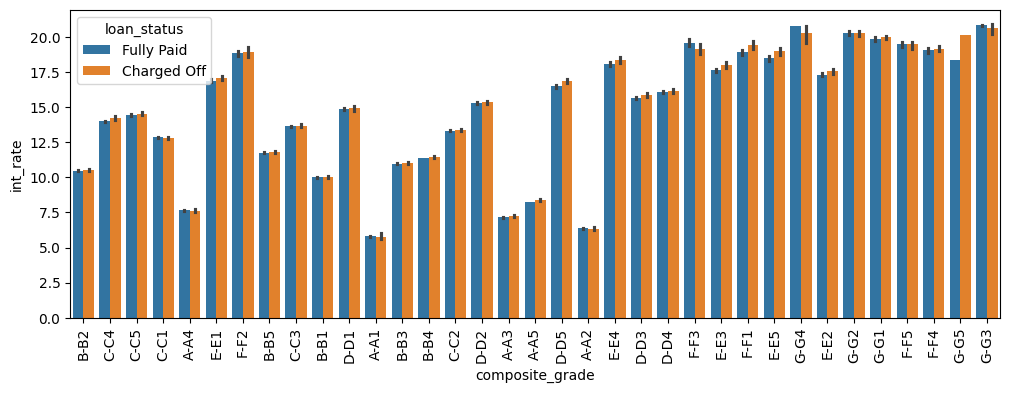

In [130]:
fig = plt.figure()
fig.set_size_inches(w=12, h=4)
sns.barplot(data=loans_defaults_or_paid, x='composite_grade', y='int_rate', hue='loan_status')
plt.xticks(rotation=90)
# plt.legend(bbox_to_anchor=(1,0.13))
fig.show()

- `Interpretation from the above plot`

  - The interest is higher for borrowers who have lower composite grades (eg: G-G3, G-G5, G-G4, F-F3 etc.)

  - Although loan interest rates fluctuate over the composite grades, they are less likely to differ between loan statuses for each composite grade. Hence we can conclude that <span style="color:blue">int_rate</span> is **highly correlated** to <span style="color:blue">composite_grade</span> of the borrowers. 

2). <span style="color:blue">ratio_installment_to_funded_amnt_inv</span> vs <span style="color:blue">composite_grade</span>

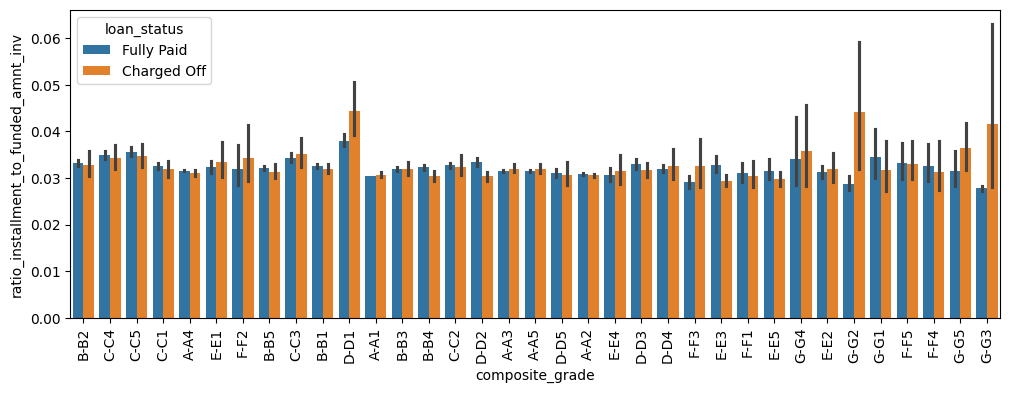

In [131]:
fig = plt.figure()
fig.set_size_inches(w=12, h=4)
sns.barplot(data=loans_defaults_or_paid, x='composite_grade', y='ratio_installment_to_funded_amnt_inv', hue='loan_status')
plt.xticks(rotation=90)
fig.show()

- `Interpretation from the above plot`

  - In addition to showing minimal variation among composite grades, the installment to investor financed amount ratio is also less likely to vary between loan statuses for the majority of composite grades except G-G2, G-G3 & D-D1. <br>Hence, <span style="color:blue">ratio_installment_to_funded_amnt_inv</span> is **highly correlated** to <span style="color:blue">composite_grade</span> of the borrowers. 

  - We need to create a new <u>Data Driven Metric</u> to eliminate the impact of this correlation on the model which may otherwise force it to overfit the dataset.

3). <span style="color:blue">annual_inc</span> vs <span style="color:blue">composite_grade</span>

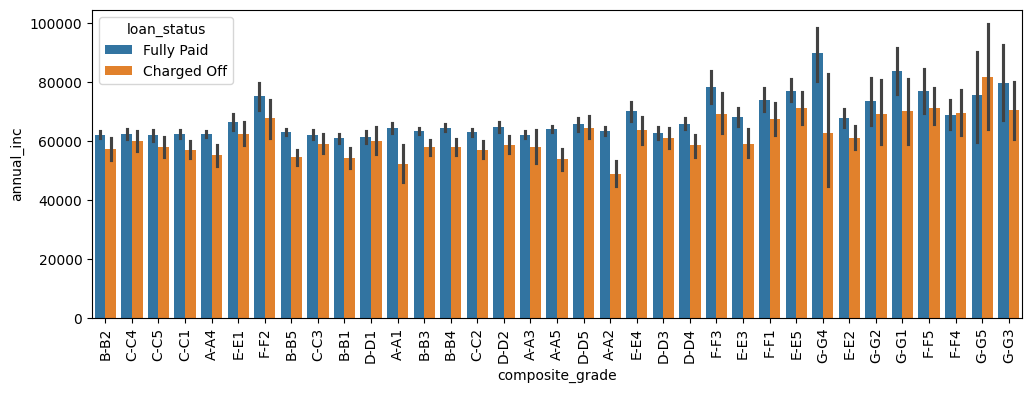

In [132]:
fig = plt.figure()
fig.set_size_inches(w=12, h=4)
sns.barplot(data=loans_defaults_or_paid, x='composite_grade', y='annual_inc', hue='loan_status')
plt.xticks(rotation=90)
fig.show()

- `Interpretation from the above plot`

  - The annual income varies little between loan statuses for a number of composite grades, with the exception of few like G-G4, G-G1, F-F3, A-A1 etc. 
  
  - Hence, <span style="color:blue">annual_inc</span> has **moderately higher correlation** with the <span style="color:blue">composite_grade</span> of the borrowers.

  - We can derive a new <u>Data Driven Metric</u>, in order to take out this correlation effect, to prevent the model from overfitting the dataset.